In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from typing import Iterable

In [3]:
import transformer_lens as tl

import einops

In [4]:
import rich
import rich.table

import dataclasses

# HookedTransformer

* [TransformerLens - Tutorial - Trains HookedTransformer from Scratch](https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/No_Position_Experiment.ipynb)

```python
import transformers

# note: it's probably easier to just operate on tokens outside of the model,
#       that'll also make it clearer where tokenizer is used
#
# okay wrapping a pretrained tokenizer *can* be done:
# - https://huggingface.co/learn/nlp-course/chapter6/8#building-a-bpe-tokenizer-from-scratch
# - but none of the models support just naive encoding
#   - https://huggingface.co/docs/tokenizers/api/models#tokenizers.models.BPE
class HookedTransformer:
    cfg: HookedTransformerConfig

    # note: actually does an `isinstance` check in the constructor
    tokenizer: transformers.PreTrainedTokenizerBase | None
```

In [5]:
import transformer_lens

from jaxtyping import Int64, Float32

import numpy as np
import plotly.express as px
import plotly.io as pio

import string
import itertools
import more_itertools
import dataclasses

import torch
import torch.utils.data

In [6]:
# plotting code copied over from transformer_lens tutorial notebook


def line(tensor: torch.Tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    labels = {"y": yaxis, "x": xaxis}
    fig = px.line(tensor, labels=labels, **kwargs)
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label
    fig.show()


def imshow(tensor: torch.Tensor, yaxis="", xaxis="", **kwargs):
    tensor = transformer_lens.utils.to_numpy(tensor)
    plot_kwargs = {
        "color_continuous_scale": "RdBu",
        "color_continuous_midpoint": 0.0,
        "labels": {"x": xaxis, "y": yaxis},
    }
    plot_kwargs.update(kwargs)
    px.imshow(tensor, **plot_kwargs).show()

In [7]:
def show_cache(cache: tl.ActivationCache) -> None:

    table = rich.table.Table("Hook Name", "Shape")

    for k, v in cache.items():
        table.add_row(k, str(v.shape))

    rich.print(table)

In [8]:
device = transformer_lens.utils.get_device()

print(f"Using device: {device}")

Using device: mps


### Setup Sample Generator

In [9]:
class SpecialToken:
    # note: as assume a BOS token because transformerlens expects it
    BOS = "<"
    # we use a EOS token for convenience
    EOS = ">"


# note: without length, the model doesn't need to learn induction heads, just directly copies


# TODO(bschoen): Allow this to generalize in the future
#
# Good for purely attention, since seeing patterns
def generate_sample_palindrome_then_repeated() -> Iterable[str]:
    """Generate palindrom samples like `<abc|cba|abc>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    lengths = [2, 3, 4, 5, 6, 7]

    # pad to max length
    max_length = 1 + max(lengths) + 1 + max(lengths) + 1 + max(lengths) + 1 + max(lengths) + 1

    # set max number to take of each length
    max_combinations_per_length = 10000

    for length in lengths:

        for combination_index, combination in enumerate(
            itertools.product(characters, repeat=length)
        ):

            if combination_index > max_combinations_per_length:
                break

            combination_str = "".join(combination)
            reversed_str = "".join(reversed(combination_str))

            sample = (
                SpecialToken.BOS
                + combination_str
                + "|"
                + reversed_str
                + "|"
                + combination_str
                + SpecialToken.EOS
            )

            # Pad the sample to max_length with EOS tokens
            padded_sample = sample.ljust(max_length, SpecialToken.EOS)

            yield padded_sample  # Return the padded sample


# TODO(bschoen): For this do we get like a "next biggest" head?
# TODO(bschoen): Can we do circuit analysis on this?
def generate_sample_sorted() -> Iterable[str]:
    """Generate sequence sorted `<cab|abc>`."""

    # Generate all combinations of lowercase letters
    characters = string.ascii_lowercase

    # note: chosen arbitrarily
    # lengths = [3, 4, 5, 6, 7]
    # lengths = [2, 3, 4, 5]  # , 6, 7]
    lengths = [4]

    # pad to max length
    max_length = 1 + max(lengths) + 1 + max(lengths) + 1

    # set max number to take of each length
    # max_combinations_per_length = 10000

    for length in lengths:

        for combination_index, combination in enumerate(
            itertools.product(characters, repeat=length)
        ):

            # if combination_index > max_combinations_per_length:
            #    break

            combination_str = "".join(combination)
            sorted_str = "".join(sorted(combination_str))

            sample = SpecialToken.BOS + combination_str + "|" + sorted_str + SpecialToken.EOS

            # Pad the sample to max_length with EOS tokens
            padded_sample = sample.ljust(max_length, SpecialToken.EOS)

            yield padded_sample  # Return the padded sample


generate_sample = generate_sample_sorted

# show a few examples
[x for x in more_itertools.take(10, generate_sample())]

['<aaaa|aaaa>',
 '<aaab|aaab>',
 '<aaac|aaac>',
 '<aaad|aaad>',
 '<aaae|aaae>',
 '<aaaf|aaaf>',
 '<aaag|aaag>',
 '<aaah|aaah>',
 '<aaai|aaai>',
 '<aaaj|aaaj>']

### Setup Tokenizer

In [10]:
from gpt_from_scratch.naive_tokenizer import NaiveTokenizer
import random

vocab = string.ascii_lowercase + "|" + SpecialToken.BOS + SpecialToken.EOS

tokenizer = NaiveTokenizer.from_text(vocab)

In [11]:
from gpt_from_scratch import tokenizer_utils

# test tokenizer
input_text = "<abc|cba|abc><bd|db|bd>>>>"
tokenizer_utils.show_token_mapping(tokenizer, input_text)

Input:		<abc|cba|abc><bd|db|bd>>>>
Tokenized:	<abc|cba|abc><bd|db|bd>>>>
Token ID | Token Bytes | Token String
---------+-------------+--------------
       0 | 3C | '<'
          <abc|cba|abc><bd|db|bd>>>>
          U+003C LESS-THAN SIGN (1 bytes: 3C)
       2 | 61 | 'a'
          <abc|cba|abc><bd|db|bd>>>>
          U+0061 LATIN SMALL LETTER A (1 bytes: 61)
       3 | 62 | 'b'
          <abc|cba|abc><bd|db|bd>>>>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       4 | 63 | 'c'
          <abc|cba|abc><bd|db|bd>>>>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
      28 | 7C | '|'
          <abc|cba|abc><bd|db|bd>>>>
          U+007C VERTICAL LINE (1 bytes: 7C)
       4 | 63 | 'c'
          <abc|cba|abc><bd|db|bd>>>>
          U+0063 LATIN SMALL LETTER C (1 bytes: 63)
       3 | 62 | 'b'
          <abc|cba|abc><bd|db|bd>>>>
          U+0062 LATIN SMALL LETTER B (1 bytes: 62)
       2 | 61 | 'a'
          <abc|cba|abc><bd|db|bd>>>>
          U+0061 LATIN SMALL LETTER A (1 by

### Setup Model Generation Function

In [12]:
from jaxtyping import Float, Int


def add_batch_dimension(x: Float32[torch.Tensor, "..."]) -> Float32[torch.Tensor, "batch ..."]:

    return einops.rearrange(x, "... -> 1 ...")


def tokenize_string(
    tokenizer: tokenizer_utils.Tokenizer,
    input_string: str,
) -> Int[torch.Tensor, "seq"]:

    tokens = tokenizer.encode(input_string)

    return torch.tensor(tokens, dtype=torch.long)


def tokenize_string_as_batch(
    tokenizer: tokenizer_utils.Tokenizer,
    input_string: str,
) -> Float32[torch.Tensor, "batch seq"]:

    return add_batch_dimension(tokenize_string(tokenizer, input_string))


def tokens_to_string(
    tokenizer: tokenizer_utils.Tokenizer,
    tokens: Int[torch.Tensor, "seq"],
) -> str:

    return tokenizer.decode(tokens.tolist())


# note: will currently generate up to context length
def generate(
    model: tl.HookedTransformer,
    tokenizer: tokenizer_utils.Tokenizer,
    input_string: str,
) -> str:

    # tokenize input string
    tokens: Int[torch.Tensor, "batch=1 seq"] = tokenize_string_as_batch(tokenizer, input_string)

    # while shorter than context length
    while tokens.shape[-1] < model.cfg.n_ctx:

        # pass current tokens through model
        logits: Float[torch.Tensor, "batch=1 seq d_vocab"] = model.forward(tokens)

        # get logits corresponding to next token
        final_logits: Float[torch.Tensor, "batch=1 d_vocab"] = logits[:, -1, :]

        # just sample the max logit (equivalent to temperature 0)
        output_tokens: Int[torch.Tensor, "batch=1"] = final_logits.argmax(-1)

        # append to tokens
        tokens = torch.cat([tokens, output_tokens.unsqueeze(-1)], dim=-1)

    # convert from tokens to string
    output_string = tokenizer.decode(tokens[0].tolist())

    return output_string

### Setup Accuracy Function

In [13]:
def evaluate_sequence_accuracy_on_test_batches(
    model: tl.HookedTransformer,
    data_loader: torch.utils.data.DataLoader,
    separator_token_id: int,
    max_batches: int | None = None,
) -> float:
    """
    Evaluates the average token-level accuracy of the model in predicting
    the second half of sequences in the test batches.

    Note:
        This holds generally for anything where we're predicting after the first `|`, which
        is the case for all the toy models we're constructing.

    Args:
        model (HookedTransformer): The trained autoregressive model.
        data_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        tokenizer (tokenizer_utils.NaiveTokenizer): The tokenizer used for encoding/decoding.
        separator_token_id (int): The token ID for the separator '|'.
        max_batches (Optional[int], optional): Maximum number of batches to evaluate.
            If None, evaluates all batches. Defaults to None.

    Returns:
        float: The average sequence-level accuracy across the evaluated batches.
    """

    # Set the model to evaluation mode
    model.eval()

    total_correct = 0
    total_samples = 0

    device = next(model.parameters()).device  # Ensure we're using the correct device

    with torch.no_grad():  # Disable gradient computation
        for batch_idx, (x, y) in enumerate(data_loader):
            if max_batches is not None and batch_idx >= max_batches:
                break

            # Move tensors to the appropriate device
            x = x.to(device)  # Shape: [batch_size, seq_length - 1]
            y = y.to(device)  # Shape: [batch_size, seq_length - 1]

            batch_size, seq_length_minus_one = y.size()

            # Convert token IDs to lists for easier manipulation
            x_tokens = x.tolist()
            y_tokens = y.tolist()

            for i in range(batch_size):
                # Reconstruct the full input and target sequences
                # Since x is tokens[:-1] and y is tokens[1:], the full sequence is x + [y[-1]]
                full_sequence = x_tokens[i] + [y_tokens[i][-1]]

                # Find the separator token position in the full sequence
                try:
                    separator_idx = full_sequence.index(separator_token_id)
                except ValueError:
                    # Separator not found; consider this sample incorrect
                    continue

                # Define the context up to and including the separator
                context = full_sequence[: separator_idx + 1]  # Include separator

                # Define the target suffix (tokens after the separator)
                target_suffix = full_sequence[separator_idx + 1 :]
                target_suffix_length = len(target_suffix)

                if target_suffix_length == 0:
                    # Nothing to generate; consider this sample correct
                    total_correct += 1
                    total_samples += 1
                    continue

                # Initialize generated sequence with the context
                #
                # Shape: [1, context_length]
                generated = torch.tensor(context, dtype=torch.long).unsqueeze(0).to(device)

                # Generate tokens step-by-step
                for _ in range(target_suffix_length):
                    # Get model logits for the current sequences
                    logits: Float32[torch.Tensor, "batch seq d_vocab"] = model.forward(generated)

                    # Get logits for the last token
                    final_logits: Float32[torch.Tensor, "batch d_vocab"] = logits[:, -1, :]

                    # Predict the next token (greedy decoding)
                    next_token = final_logits.argmax(dim=-1)  # Shape: [batch_size]

                    # Append the predicted token to the generated sequence
                    #
                    # Shape: [1, seq_length + 1]
                    generated = torch.cat([generated, next_token.unsqueeze(-1)], dim=-1)

                # Extract the generated suffix
                generated_suffix = generated[0, separator_idx + 1 :].tolist()

                # Compare the entire generated suffix with the target suffix
                if generated_suffix == target_suffix:
                    total_correct += 1
                total_samples += 1

    # Set the model back to training mode
    model.train()

    # Compute average accuracy
    average_accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    return average_accuracy

### Setup Loss Function

In [14]:
def loss_fn(logits, target):
    # standard cross entropy loss
    return torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),
        target.view(-1),
    )

### Evaluate On Test

In [15]:
def evaluate_loss_on_test_batches(
    model: transformer_lens.HookedTransformer,
    data_loader: torch.utils.data.DataLoader,
    max_batches: int,
) -> float:

    # Set the model to evaluation mode
    model.eval()

    losses = []

    with torch.no_grad():  # Disable gradient computation

        for batch_index, batch in enumerate(data_loader):

            if batch_index > max_batches:
                break

            x, y = batch

            x, y = x.to(device), y.to(device)

            logits = model(x)

            loss = loss_fn(logits, y)

            losses.append(loss.item())

    # Set the model back to training mode
    model.train()

    return sum(losses) / len(losses)

### Setup Data Loaders

In [16]:
class AutoregressiveDataset(torch.utils.data.Dataset):
    def __init__(self, samples: list[str], tokenizer: NaiveTokenizer) -> None:
        self.samples = samples
        self.tokenizer = tokenizer  # Assuming tokenizer is defined in the global scope

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        tokens = self.tokenizer.encode(sample)

        # Convert to tensor and add batch dimension
        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)

        return x, y


def make_batch_dataloader(
    samples: list[str],
    tokenizer: NaiveTokenizer,
    batch_size: int,
) -> tuple[torch.utils.data.Dataset, torch.utils.data.DataLoader]:

    dataset = AutoregressiveDataset(samples=samples, tokenizer=tokenizer)

    # Create DataLoader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        # drop the last batch if it's incomplete
        drop_last=True,
    )

    return dataset, dataloader


# Example usage:
# batch_generator = make_batch_generator(tokenizer, batch_size=4)
# for x, y in batch_generator:
#     # x is input, y is target (x shifted by 1)
#     pass

In [17]:
import random

# split into test and train
all_samples = list(generate_sample())

# note: 4394 batches = (26 * 26 * 26) / 4
print(f"{len(all_samples)} samples")

# Randomly shuffle all_samples
random.shuffle(all_samples)  # In-place shuffling of the list

# Inline comment explaining the motivation
# We shuffle the samples to ensure a random distribution of data points
# between the training and test sets, reducing potential bias


# max_samples = 10
# print(f'Capping at {max_samples} batches first to make sure we can overfit')
# all_samples = all_samples[:max_samples]

test_train_ratio = 0.2

test_size = int(test_train_ratio * len(all_samples))

# put remaining ones into train
train_size = len(all_samples) - test_size

train_samples = all_samples[:train_size]
test_samples = all_samples[train_size:]

print(f"{len(train_samples)=}")
print(f"{len(test_samples)=}")

# now we can finally construct dataloaders
# batch_size = 128
batch_size = 512

train_dataset, train_loader = make_batch_dataloader(
    samples=train_samples,
    tokenizer=tokenizer,
    batch_size=batch_size,
)
# Split test_samples based on the number of '>' characters
test_samples_by_difficulty = {}
for sample in test_samples:
    difficulty = len(sample) - sample.count(">")
    if difficulty not in test_samples_by_difficulty:
        test_samples_by_difficulty[difficulty] = []
    test_samples_by_difficulty[difficulty].append(sample)

# Sort the dictionary by difficulty (number of '>' characters)
test_samples_by_difficulty = dict(sorted(test_samples_by_difficulty.items(), reverse=True))

# Inline comment explaining the motivation
# We sort the dictionary by difficulty to ensure a consistent order
# when iterating through the difficulty levels, making it easier to
# analyze and compare model performance across increasing complexities

for difficulty, samples in test_samples_by_difficulty.items():
    print(f"{difficulty}: {len(samples)}")

# Create dataloaders for each difficulty level
test_datasets = {}
test_loaders = {}
for difficulty, samples in test_samples_by_difficulty.items():
    test_datasets[difficulty], test_loaders[difficulty] = make_batch_dataloader(
        samples=samples,
        tokenizer=tokenizer,
        batch_size=batch_size,
    )

# Inline comment explaining the motivation
# We split the test samples based on the number of '>' characters to create
# separate datasets for different difficulty levels. This allows us to evaluate
# the model's performance across varying complexities of input sequences.

456976 samples
len(train_samples)=365581
len(test_samples)=91395
10: 91395


### Setup Model

In [18]:
# now we know our vocab size from our sample generation
def make_hooked_transformer_config(
    n_layers: int,
    d_model: int,
    n_heads: int,
) -> transformer_lens.HookedTransformerConfig:

    for sample in generate_sample():
        n_ctx = len(sample)
        break

    cfg = transformer_lens.HookedTransformerConfig(
        n_layers=n_layers,
        d_model=d_model,
        d_head=d_model // n_heads,
        # The number of attention heads.
        # If not specified, will be set to d_in // d_head.
        # (This is represented by a default value of -1)
        n_heads=n_heads,
        # The dimensionality of the feedforward mlp network.
        # Defaults to 4 * d_in, and in an attn-only model is None.
        # TODO(bschoen): Need to try out also setting `attn_only`
        # d_mlp=None,
        # note: transformerlens does the same thing if this is not set
        d_vocab=len(tokenizer.byte_to_token_dict),
        # length of the longest sample is our context length
        n_ctx=n_ctx,
        act_fn="relu",
        # normalization_type="LN",
        normalization_type=None,
        # note: must be set, otherwise tries to default to cuda / cpu (not mps)
        device=device.type,
    )

    print(f"Num params: {cfg.n_params}")

    return cfg

## Setup Image Logging

In [19]:
# Convert matplotlib figure to PNG for wandb upload
import io
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Any
from jaxtyping import Float


def fig_to_wandb_image(fig) -> Image:
    """
    Convert a matplotlib figure to a PNG image that can be uploaded to wandb.

    Args:
        fig (matplotlib.figure.Figure): The matplotlib figure to convert

    Returns:
        PIL.Image: The figure as a PIL Image object
    """
    # Save the figure to a byte buffer
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=300, bbox_inches="tight")
    buf.seek(0)

    # Convert the buffer to a PIL Image
    image = Image.open(buf)
    return image


# note: `title` is passed in for telling them apart in gifs etc
def generate_image_for_attention_patterns(
    input_token_str_to_cache_dict: dict[str, transformer_lens.ActivationCache],
    title: str,
) -> Image:
    """
    Visualize attention patterns for all layers and heads in the model for multiple caches.

    Args:
        caches (List[Dict[str, Any]]): List of caches containing attention patterns from model forward passes.

    Returns:
        plt.Figure: A matplotlib figure containing the visualized attention patterns.
    """
    input_token_strings = list(input_token_str_to_cache_dict.keys())
    caches = list(input_token_str_to_cache_dict.values())

    # Find all attention pattern tensors in the first cache (assuming all caches have the same structure)
    pattern_keys = [key for key in caches[0].keys() if key.endswith(".attn.hook_pattern")]

    n_layers = len(pattern_keys)
    n_heads = caches[0][pattern_keys[0]].shape[1]
    n_caches = len(caches)

    # Calculate total number of subplots
    total_subplots = n_layers * n_heads

    # Create a figure with subplots stacked vertically for each cache
    fig, axes = plt.subplots(n_caches, total_subplots, figsize=(4 * total_subplots, 4 * n_caches))

    # Set overall figure title
    fig.suptitle(title, fontsize=16)

    # Color maps for alternating heads
    cmaps = ["Blues", "Reds"]

    for cache_idx, cache in enumerate(caches):
        input_token_string = input_token_strings[cache_idx]
        for layer, key in enumerate(pattern_keys):
            attention_pattern = cache[key]

            # Remove batch dimension and move to CPU
            reshaped_pattern = attention_pattern.squeeze(0).detach().cpu().numpy()

            for head in range(n_heads):
                subplot_index = layer * n_heads + head
                ax = axes[cache_idx, subplot_index] if n_caches > 1 else axes[subplot_index]

                # Plot the attention pattern
                im = ax.imshow(reshaped_pattern[head], cmap=cmaps[head % len(cmaps)])

                # Set title for each subplot
                ax.set_title(f"L{layer}-H{head}", fontsize=8)

                # Set column labels as individual characters from input_token_string at the top
                ax.xaxis.tick_top()
                ax.set_xticks(range(len(input_token_string)))
                ax.set_xticklabels(list(input_token_string), fontsize=6, ha="right")

                ax.set_yticks([])  # Remove y-axis ticks

    plt.tight_layout()

    image = fig_to_wandb_image(fig)

    # close figure so doesn't keep taking up memory
    plt.close(fig)

    return image

In [20]:
import glob
from PIL import Image
import os
import pathlib


def convert_pngs_in_directory_to_gif(output_dir: pathlib.Path) -> pathlib.Path:

    # Get a list of all PNG files in the output directory
    # Use rglob for recursive search of PNG files
    png_files = list(output_dir.rglob("*.png"))

    # sort by step
    #
    # files have format
    #
    # - `.../<key>_<step>_<hash-identifier-thing>.png`
    # - ex: `.../attention_100_d8bda3455ffb06855d88.png`
    #
    png_files = sorted(png_files, key=lambda x: int(x.name.split("_")[1]))

    # Create a list to store the image frames
    frames = []

    # Load each PNG file and append it to the frames list
    print(f"Generating gif from {len(png_files)} images...")
    for png_file in png_files:
        # Open the image and convert it to RGB mode (required for GIF)
        img = Image.open(str(png_file)).convert("RGB")
        frames.append(img)

    # Define the output GIF filename
    gif_filename = output_dir / "attention_pattern_evolution.gif"

    # Save the frames as an animated GIF
    print(f"Saving gif from {len(frames)} frames to {gif_filename}...")
    frames[0].save(
        gif_filename,
        save_all=True,
        append_images=frames[1:],
        optimize=False,
        duration=200,  # Duration between frames in milliseconds
        loop=0,  # 0 means loop indefinitely
    )

    print(f"GIF created and saved as: {gif_filename}")

    # Optionally, log the GIF to wandb
    # wandb.log({"attention_pattern_evolution": wandb.Image(str(gif_filename))})

    return gif_filename

In [21]:
class WandbConstants:
    ENTITY = "bronsonschoen-personal-use"
    PROJECT = "toy-problem-hooked-transformer-v6"
    NAME = "toy-sequence"
    ATTENTION_PATTERN_IMAGES = "attention"

In [22]:
LossValue = float


@dataclasses.dataclass(frozen=True)
class TrainModelResult:
    model: transformer_lens.HookedTransformer

    # returned because optuna needs it
    # TODO(bschoen): Is this usually val loss?
    train_loss: LossValue

    # useful to retrieve files
    wandb_run_name: str
    wandb_run_id: str

In [23]:
import wandb
import pathlib
import tqdm


def download_images_from_run(result: TrainModelResult) -> pathlib.Path:

    # write things to run specific directory
    output_dir = pathlib.Path(f"wandb_artifacts/{result.wandb_run_id}")

    # create output dir if not exists
    output_dir.mkdir(exist_ok=True, parents=True)

    api = wandb.Api()

    identifier = "/".join(
        [
            WandbConstants.ENTITY,
            WandbConstants.PROJECT,
            result.wandb_run_id,
        ]
    )

    print(f"Downloading {identifier}...")
    run = api.run(identifier)

    # filter down to just attention pattern images
    files = [
        x
        for x in run.files()
        if x.name.startswith(f"media/images/{WandbConstants.ATTENTION_PATTERN_IMAGES}")
    ]

    for file in tqdm.tqdm(desc="Downloading images...", iterable=files):

        print(f"Downloading {file.name}")
        file.download(
            root=str(output_dir),
            replace=False,
            exist_ok=True,
            api=api,
        )

    return output_dir

## Training

In [24]:
# TODO(bschoen): Holdout set of n+1 length

In [25]:
import tqdm

import torch.optim

import wandb

import dataclasses
import json

import time


def print_json(value):
    print(json.dumps(value, indent=2))


# everything customizable via optuna
@dataclasses.dataclass(frozen=True)
class ModelAndTrainingConfig:

    # input
    train_loader: torch.utils.data.DataLoader
    test_loaders: dict[int, torch.utils.data.DataLoader]

    # training
    num_epochs: int = 10000
    eval_test_every_n: int = 500
    wait_between_eval_s: int | None = None

    # model
    n_layers: int = 2
    d_model: int = 16
    n_heads: int = 2

    # optimizers
    betas: tuple[float, float] = (0.9, 0.999)
    learning_rate: float = 1e-3
    max_grad_norm: float = 1.0
    weight_decay: float = 0.1

    def get_hooked_transformer_config(self) -> transformer_lens.HookedTransformerConfig:
        return make_hooked_transformer_config(
            n_layers=self.n_layers,
            d_model=self.d_model,
            n_heads=self.n_heads,
        )

    def to_dict(self) -> dict[str, str | int]:
        dict_repr = dataclasses.asdict(self)
        dict_repr.pop("train_loader")
        dict_repr.pop("test_loaders")
        return dict_repr


def train_model(cfg: ModelAndTrainingConfig) -> TrainModelResult:

    # create new model instance
    ht_cfg = cfg.get_hooked_transformer_config()
    model = transformer_lens.HookedTransformer(ht_cfg)

    # setup optimizers
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.learning_rate,
        betas=cfg.betas,
        weight_decay=cfg.weight_decay,
    )
    # scheduler = torch.optim.lr_scheduler.LambdaLR(
    #    optimizer, lambda i: min(i / 100, 1.0)
    # )

    num_epochs = cfg.num_epochs

    # setup wandb
    wandb.init(
        project=WandbConstants.PROJECT,
        name=WandbConstants.NAME,
        config=cfg.to_dict(),
    )

    print(f"Run name {wandb.run.name} - {wandb.run.id}")

    # create a small (fixed) training set of each difficulty to use for visualization
    test_example_per_difficulty = {}
    for difficulty, test_loader in cfg.test_loaders.items():
        # grab something from the test batch
        x, _ = next(iter(test_loader))
        input_tokens = x[0].to(device)
        test_example_per_difficulty[difficulty] = input_tokens

    losses = []

    for epoch, batch in tqdm.tqdm(
        zip(
            range(num_epochs),
            itertools.cycle(train_loader),
        )
    ):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # ex: torch.Size([4, 9, 29])
        logits: Float32[torch.Tensor, "b t c"] = model(tokens)

        # print(f"Logits:\n{logits.shape}")
        loss = loss_fn(logits, target)

        loss.backward()

        if cfg.max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)

        optimizer.step()

        optimizer.zero_grad()

        # scheduler.step()

        losses.append(loss.item())

        # more frequently than eval, print out train loss
        # if (epoch % (cfg.eval_test_every_n // 10)) == 0:
        #
        #    print(f"Epoch {epoch}, " f"Train loss: {loss.item():.6f}")

        # TODO(bschoen): Shouldn't you actually divide loss by batch size?
        # TODO(bschoen): Do we want like an `is trial` (for example logging last one)
        if (epoch % cfg.eval_test_every_n) == 0:

            # skip evaluating test loss if we just started training
            # if epoch == 0:
            #    continue

            print("Evaluating test loss...")

            # compute loss at each difficulty
            test_loss_by_difficulty = {}
            test_accuracy_by_difficulty = {}

            for difficulty, test_loader in cfg.test_loaders.items():

                test_loss = evaluate_loss_on_test_batches(
                    model,
                    test_loader,
                    max_batches=100,
                )

                accuracy = evaluate_sequence_accuracy_on_test_batches(
                    model,
                    test_loader,
                    separator_token_id=tokenizer.encode("|")[0],
                    max_batches=1,
                )

                test_loss_by_difficulty[difficulty] = test_loss
                test_accuracy_by_difficulty[difficulty] = accuracy

            wandb_log_dict = {"epoch": epoch, "train_loss": loss.item()}

            for difficulty, test_loss in test_loss_by_difficulty.items():

                wandb_log_dict[f"test_loss_difficulty_{difficulty}"] = test_loss

            for difficulty, accuracy in test_accuracy_by_difficulty.items():

                wandb_log_dict[f"test_accuracy_difficulty_{difficulty}"] = accuracy

            # evaluate accuracy
            print("Evaluating accuracy...")

            print(f"Accuracy: {accuracy}")

            # print_json(wandb_log_dict)

            # Log metrics
            wandb.log(wandb_log_dict, step=epoch)

            # Compute attention pattern visualization
            print("Computing attention pattern visualization...")
            model.eval()
            test_example_string_to_cache = {}

            for difficulty, input_tokens in test_example_per_difficulty.items():

                logits, cache = model.run_with_cache(input_tokens)

                # store example by using the actual text string as key
                input_tokens_str = "".join([tokenizer.decode([x.item()]) for x in input_tokens])

                test_example_string_to_cache[input_tokens_str] = cache

            image = generate_image_for_attention_patterns(
                test_example_string_to_cache,
                title=f"Step: {epoch}",
            )

            wandb.log(
                {WandbConstants.ATTENTION_PATTERN_IMAGES: wandb.Image(image)},
                step=epoch,
            )

            if cfg.wait_between_eval_s and cfg.wait_between_eval_s is not None:
                print(f"Sleeping for {cfg.wait_between_eval_s} to avoid wandb rate limiting")
                time.sleep(cfg.wait_between_eval_s)

    # capture run name and id before `finish`
    wandb_run_name = wandb.run.name
    wandb_run_id = wandb.run.id

    wandb.finish()

    # log locally to sanity check
    # px.line(losses, labels={"x": "Epoch", "y": "Train Loss"})

    print(f"Final train loss: {loss.item():.6f}")

    # take model out of train
    model.eval()

    return TrainModelResult(
        model=model,
        train_loss=loss.item(),
        wandb_run_name=wandb_run_name,
        wandb_run_id=wandb_run_id,
    )


# note: There's a floor to our loss here, which is the first N digits before `|`

# TODO(bschoen): Generate attention pattern for heads that have to handle different arrangements
#                in case it's more clear what they're doing
#
# TODO(bschoen): There's only a finite number of permutations, can just generate the flow for each

# train brief run to test code
training_config = ModelAndTrainingConfig(
    num_epochs=10000,
    eval_test_every_n=1000,
    weight_decay=0.1,
    wait_between_eval_s=None,
    train_loader=train_loader,
    test_loaders=test_loaders,
)

result = train_model(training_config)

# for compatibility with code later
model = result.model
cfg = training_config.get_hooked_transformer_config()

Num params: 6144


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bronsonschoen (bronsonschoen-personal-use). Use `wandb login --relogin` to force relogin


Run name toy-sequence - plmn7eu9


0it [00:00, ?it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.0
Computing attention pattern visualization...


998it [00:21, 86.01it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.4375
Computing attention pattern visualization...


1996it [00:38, 95.26it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.880859375
Computing attention pattern visualization...


2992it [00:54, 97.26it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.94921875
Computing attention pattern visualization...


3994it [01:10, 87.12it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.970703125
Computing attention pattern visualization...


4993it [01:26, 86.45it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.98828125
Computing attention pattern visualization...


5992it [01:43, 88.53it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.986328125
Computing attention pattern visualization...


6992it [01:59, 89.61it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.9921875
Computing attention pattern visualization...


7998it [02:16, 91.45it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.99609375
Computing attention pattern visualization...


8996it [02:32, 95.97it/s]

Evaluating test loss...
Evaluating accuracy...
Accuracy: 0.9921875
Computing attention pattern visualization...


10000it [02:48, 59.28it/s]


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy_difficulty_10,▁▄▇███████
test_loss_difficulty_10,█▂▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁
epoch,9000
test_accuracy_difficulty_10,0.99219
test_loss_difficulty_10,1.30711
train_loss,1.30645


Final train loss: 1.305617
Num params: 6144


## Save Output Image To Gif

In [ ]:
output_dir = download_images_from_run(result=result)

gif_filepath = convert_pngs_in_directory_to_gif(output_dir=output_dir)

print(gif_filepath)

## Looking At Embedding For Sorted Order

Actually assuming positional embedding these get different values anyway, was worth it to check that they aren't just learned in the embedding

### PCA

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from jaxtyping import Float

# Assuming 'model' is your HookedTransformer instance
embeddings: Float[torch.Tensor, "vocab_size d_model"] = model.embed.W_E.detach().cpu().numpy()


# Apply PCA
pca = PCA(n_components=2)
reduced_embeddings: Float[torch.Tensor, "vocab_size 2"] = pca.fit_transform(embeddings)


# Plot
plt.figure(figsize=(10, 8))
for i, label in enumerate(vocab):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)

# Print the total variance explained

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = sum(explained_variance_ratio)
print(f"Total variance explained by 2 principal components: {total_variance_explained:.2%}")

plt.title(
    "2D Visualization of Character Embeddings"
    f"\nTotal Variance Explained: {total_variance_explained:.2%}"
)
plt.xlabel(f"PC1 ({explained_variance_ratio[0]:.2%} variance explained)")
plt.ylabel(f"PC2 ({explained_variance_ratio[1]:.2%} variance explained)")
plt.ylim(-1, 1)  # Set y-axis range to -1 to 1
plt.xlim(-1, 1)  # Set x-axis range to -1 to 1
plt.show()

### Examine Embedding Dimensions Individually

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from jaxtyping import Float

embeddings: Float[torch.Tensor, "vocab_size embedding_dim"] = model.embed.W_E.detach().cpu().numpy()

# Assuming 'embeddings' is of shape (vocab_size, embedding_dim)
# Transpose embeddings to have dimensions on the rows and tokens on the columns
embeddings_transposed = embeddings.T  # Shape: (embedding_dim, vocab_size)

plt.figure(figsize=(12, 8))
plt.imshow(embeddings_transposed, aspect="auto", cmap="RdBu_r", interpolation="none")

plt.colorbar(label="Embedding Value")
plt.title("Embedding Heatmap")
plt.xlabel("Token")
plt.ylabel("Embedding Dimension")

# Set x-axis ticks to tokens
plt.xticks(ticks=np.arange(len(vocab)), labels=vocab, rotation="vertical", fontsize=8)
# Set y-axis ticks to embedding dimensions
embedding_dim = embeddings.shape[1]
plt.yticks(ticks=np.arange(embedding_dim), labels=np.arange(embedding_dim))

# Optionally, set color limits to be symmetric around zero
plt.clim(-1, 1)  # Adjust based on the range of your embeddings

plt.tight_layout()
plt.show()

In [ ]:
import rich
import rich.table
import scipy.stats

# A high positive or negative correlation in a dimension suggests that
# the dimension encodes character order.

char_indices = np.arange(len(vocab))

# Create a rich table to display correlation coefficients and p-values
table = rich.table.Table("Dimension", "Corr Coef", "p-value")

for dim in range(embedding_dim):

    corr_coef, p_value = scipy.stats.pearsonr(embeddings[:, dim], char_indices)

    table.add_row(f"{dim}", f"{corr_coef:.3f}", f"{p_value:.3}")

rich.print(table)

### Compute Pairwise Distances Between Embeddings

In [ ]:
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

for metric in ["euclidean", "cosine"]:
    # Compute the distance matrix
    distance_matrix = squareform(pdist(embeddings, metric=metric))

    # Zero out the upper triangular part of the matrix
    # distance_matrix = np.tril(distance_matrix)  # Keep only lower triangular part

    plt.figure(figsize=(10, 8))
    sns.heatmap(distance_matrix, xticklabels=vocab, yticklabels=vocab, cmap="RdBu")
    plt.title(f"Pairwise {metric} Distances Between Embeddings (Lower Triangle)")
    plt.xlabel("Character")
    plt.ylabel("Character")
    plt.show()

### Visualize Embeddings Using Nonlinear Dimensionality Reduction

ex: Sequential Arrangement: Characters may arrange in a curve or line reflecting their order.

This is just PCA in this case

In [ ]:
from sklearn.manifold import TSNE

# Calculate the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to be less than n_samples (e.g., half of n_samples or 30, whichever is smaller)
perplexity = min(30, n_samples // 2)

tsne_embeddings = TSNE(n_components=2, random_state=42, perplexity=perplexity).fit_transform(
    embeddings
)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1])

for i, label in enumerate(vocab):
    x, y = tsne_embeddings[i]
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)

plt.title("t-SNE Visualization of Token Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Analyze Principal Components in Detail

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=embedding_dim)
pca_embeddings = pca.fit_transform(embeddings)
explained_variance = pca.explained_variance_ratio_

# plot the explained variance for each principal component
plt.figure(figsize=(8, 4))
plt.bar(range(1, embedding_dim + 1), explained_variance * 100)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.title("PCA Explained Variance")
plt.show()

# plot irst few principal components
for i in range(5):

    corr_coef, p_value = scipy.stats.pearsonr(pca_embeddings[:, i], char_indices)
    print(
        f"{i}-th Principal Component vs Character Index: "
        f"Correlation Coefficient = {corr_coef:.3f}, p-value = {p_value:.3}"
    )

    plt.figure(figsize=(8, 4))
    plt.plot(char_indices, pca_embeddings[:, i], marker="o")
    plt.title(f"{i}-th Principal Component of Embeddings")
    plt.xlabel("Character Index")
    plt.ylabel(f"PCA Component {i}")
    plt.xticks(char_indices, vocab)
    plt.grid(True)
    plt.show()

## Indirect Object Identification

In [ ]:
import einops
import circuitsvis as cv


def add_batch_dimension(x: Float32[torch.Tensor, "..."]) -> Float32[torch.Tensor, "batch ..."]:
    return einops.rearrange(x, "... -> 1 ...")


def tokenize_string(input_string: str) -> Float32[torch.Tensor, "seq"]:

    tokens = tokenizer.encode(input_string)

    return torch.tensor(tokens, dtype=torch.long).to(device)


def tokenize_string_as_batch(input_string: str) -> Float32[torch.Tensor, "batch seq"]:

    return add_batch_dimension(tokenize_string(input_string))


def get_first_mismatched_pair(
    tokens_a: Float32[torch.Tensor, "batch=1 seq"],
    tokens_b: Float32[torch.Tensor, "batch=1 seq"],
) -> Float32[torch.Tensor, "batch=1 2"]:

    assert tokens_a.shape == tokens_b.shape

    for index in range(tokens_a.shape[-1]):

        if tokens_a[0, index] != tokens_b[0, index]:

            mismatch: Float32[torch.Tensor, "2"] = torch.tensor(
                [
                    tokens_a[0, index],
                    tokens_b[0, index],
                ]
            ).to(device)

            return add_batch_dimension(mismatch)


# create a custom to_string function since using our own tokenizer
def token_to_string(token: int) -> str:
    return tokenizer.decode([token])


# TODO(bschoen): Vary along things besides reversal

# take an example, modify the first part of the sequence reversal to be wrong
input_string = "<bacd|ab"
correct_string = f"{input_string}c"
incorrect_string = f"{input_string}d"

input_string_tokens = tokenize_string_as_batch(input_string)
correct_string_tokens = tokenize_string_as_batch(correct_string)
incorrect_string_tokens = tokenize_string_as_batch(incorrect_string)

logits, cache = model.run_with_cache(input_string_tokens)
correct_logits, correct_cache = model.run_with_cache(correct_string_tokens)
incorrect_logits, incorrect_cache = model.run_with_cache(incorrect_string_tokens)

In [ ]:
display(
    cv.logits.token_log_probs(
        token_indices=correct_string_tokens,
        log_probs=correct_logits.log_softmax(dim=-1),
        to_string=token_to_string,
    )
)

display(
    cv.logits.token_log_probs(
        token_indices=incorrect_string_tokens,
        log_probs=incorrect_logits.log_softmax(dim=-1),
        to_string=token_to_string,
    )
)

In [ ]:
# position where we changed the sequence
if False:
    mismatch_position_index = 4

    correct_token = correct_string_tokens[0, mismatch_position_index].item()
    incorrect_token = incorrect_string_tokens[0, mismatch_position_index].item()

    print(f"correct_token: {correct_token} ({tokenizer.decode([correct_token])})")
    print(f"incorrect_token: {incorrect_token} ({tokenizer.decode([incorrect_token])})")

### Logit Difference In Accumulated Residual Stream

In [ ]:
# get diff in format expected by `model.tokens_to_residual_directions`
answer_tokens = get_first_mismatched_pair(
    correct_string_tokens,
    incorrect_string_tokens,
)

print(f"{answer_tokens.shape=}")

# Float32[torch.Tensor, "batch 2 d_model"]
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)

print("Answer residual directions shape:", answer_residual_directions.shape)

# Float32[torch.Tensor, "batch d_model"]
# Float32[torch.Tensor, "batch d_model"]
correct_residual_directions, incorrect_residual_directions = answer_residual_directions.unbind(
    dim=1
)

# Float32[torch.Tensor, "batch d_model"]
logit_diff_directions = correct_residual_directions - incorrect_residual_directions

print(f"Logit difference directions shape:", logit_diff_directions.shape)

In [ ]:
from gpt_from_scratch import transformer_lens_utils

import transformer_lens.patching

In [ ]:
original_per_prompt_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    logits,
    answer_tokens,
    per_prompt=True,
)
print("Per prompt logit difference:", original_per_prompt_diff)

original_average_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    logits,
    answer_tokens,
)
print("Average logit difference:", original_average_logit_diff)

In [ ]:
for k, v in cache.items():
    print(f"{k} {v.shape=}")

In [ ]:
# approximate layernorms as constants when propagating feature vectors backward
# for theoretical motivation, see the LayerNorm section of
# 	https://www.neelnanda.io/mechanistic-interpretability/attribution-patching
@torch.no_grad()
def get_ln_constant(model, cache, vector, layer, token, is_ln2=False, recip=False):
    x_act_name = (
        transformer_lens.utils.get_act_name("resid_mid", layer)
        if is_ln2
        else transformer_lens.utils.get_act_name("resid_pre", layer)
    )
    x = cache[x_act_name][0, token]

    y_act_name = get_act_name("normalized", layer, "ln2" if is_ln2 else "ln1")
    y = cache[y_act_name][0, token]

    if torch.dot(vector, x) == 0:
        return torch.tensor(0.0)
    return (
        torch.dot(vector, y) / torch.dot(vector, x)
        if not recip
        else torch.dot(vector, x) / torch.dot(vector, y)
    )

In [ ]:
def residual_stack_to_logit_diff(
    residual_stack: Float32[torch.Tensor, "... batch d_model"],
    cache: transformer_lens.ActivationCache,
    logit_diff_directions: Float[torch.Tensor, "batch d_model"],
) -> Float32[torch.Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given
    stack of components in the residual stream.
    """
    # SOLUTION
    batch_size = residual_stack.size(-2)
    """scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack,
        layer=-1,
        pos_slice=-1,
    )"""
    return (
        einops.einsum(
            residual_stack,
            logit_diff_directions,
            "... batch d_model, batch d_model -> ...",
        )
        / batch_size
    )

In [ ]:
# we expected residual stream patching near the final layer to work near perfectly,
# since it was logit focused and thus basically linear, but turns out that
# LayerNorm completely breaks things.

# note: the fact that we had to use `ln_final.hook_normalized` instead of `resid_post`
#       means that center_writing_weights is needed

final_residual_stream = cache["resid_post", -1]  # [batch seq d_model]
# final_residual_stream = cache["ln_final.hook_normalized"]  # [batch seq d_model]
print(f"Final residual stream shape: {final_residual_stream.shape}")
final_token_residual_stream = final_residual_stream[:, -1, :]  # [batch d_model]

# Apply LayerNorm scaling (to just the final sequence position)
# pos_slice is the subset of the positions we take - here the final token of each prompt
# scaled_final_token_residual_stream = cache.apply_ln_to_stack(
#     final_token_residual_stream,
#     layer=-1,
#     pos_slice=-1,
# )
scaled_final_token_residual_stream = final_token_residual_stream

batch_size = input_string_tokens.shape[0]

average_logit_diff = (
    einops.einsum(
        scaled_final_token_residual_stream,
        logit_diff_directions,
        "batch d_model, batch d_model ->",
    )
    / batch_size
)

print("Note: These should be close!")
print(f"Calculated average logit diff: {average_logit_diff:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

In [ ]:
result = residual_stack_to_logit_diff(
    final_token_residual_stream,
    cache,
    logit_diff_directions,
)

print("Note: These should be close!")
print(f"Calculated average logit diff: {result:.10f}")
print(f"Original logit difference:     {original_average_logit_diff:.10f}")

In [ ]:
#

In [ ]:
accum_resid, labels = cache.accumulated_resid(return_labels=True, apply_ln=True)
last_token_accum = accum_resid[:, 0, -1, :]  # layer, batch, pos, d_model
print(f"{last_token_accum.shape=}")  # layer, batch, d_model

In [ ]:
W_U = model.W_U
print(f"{W_U.shape=}")

In [ ]:
layers_unembedded = einops.einsum(
    last_token_accum,
    W_U,
    "layer d_model, d_model d_vocab -> layer d_vocab",
)

print(f"{layers_unembedded.shape=}")

In [ ]:
logit_lens_logit_diffs: Float32[torch.Tensor, "..."] = residual_stack_to_logit_diff(
    accum_resid,
    cache,
    logit_diff_directions,
)  # [component]

In [ ]:
print(model.cfg)
print(model)

In [ ]:
from gpt_from_scratch import plotly_utils


accumulated_residual, labels = cache.accumulated_resid(
    layer=-1,
    incl_mid=True,
    pos_slice=-1,
    return_labels=True,
)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs: Float32[torch.Tensor, "..."] = residual_stack_to_logit_diff(
    accumulated_residual,
    cache,
    logit_diff_directions,
)  # [component]

plotly_utils.line(
    logit_lens_logit_diffs,
    hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800,
)

### Logit Difference From Each Layer

In [ ]:
per_layer_residual, labels = cache.decompose_resid(
    layer=-1,
    pos_slice=-1,
    return_labels=True,
)
per_layer_logit_diffs = residual_stack_to_logit_diff(
    per_layer_residual,
    cache,
    logit_diff_directions,
)

plotly_utils.line(
    per_layer_logit_diffs,
    hovermode="x unified",
    title="Logit Difference From Each Layer",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800,
)

### Logit Difference From Each Head

In [ ]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(
    per_head_residual,
    "(layer head) ... -> layer head ...",
    layer=model.cfg.n_layers,
)
per_head_logit_diffs = residual_stack_to_logit_diff(
    per_head_residual,
    cache,
    logit_diff_directions,
)

plotly_utils.imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    width=600,
)

### Highest Value Attention Heads

In [ ]:
import IPython.core.display
import IPython.display


def topk_of_Nd_tensor(
    tensor: Float[torch.Tensor, "rows cols"],
    k: int,
) -> list[tuple[int, int]]:
    """
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    """
    i = torch.topk(tensor.flatten(), k).indices
    return np.array(
        np.unravel_index(
            transformer_lens.utils.to_numpy(i),
            tensor.shape,
        )
    ).T.tolist()


k = 3

for head_type in ["Positive", "Negative"]:

    # Get the heads with largest (or smallest) contribution to the logit difference
    top_heads = topk_of_Nd_tensor(
        per_head_logit_diffs.cpu() * (1 if head_type == "Positive" else -1), k
    )

    # ex: [[0, 1], [1, 0], [0, 0]]
    print(top_heads)

    # Get all their attention patterns
    attn_patterns_for_important_heads: Float[torch.Tensor, "head q k"] = torch.stack(
        [cache["pattern", layer][:, head][0] for layer, head in top_heads]
    )

    print(f"{attn_patterns_for_important_heads.shape=}")

    # Display results
    display(
        cv.attention.attention_heads(
            attention=attn_patterns_for_important_heads,
            tokens=[x for x in input_string],
            attention_head_names=[f"{layer}.{head}" for layer, head in top_heads],
        )
    )

    break

### Activation Patching

In [ ]:
from gpt_from_scratch import transformer_lens_utils

# TODO(bschoen): Clean and corrupted should actually switch first, should do this for search
clean_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    correct_logits,
    answer_tokens,
)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(
    incorrect_logits,
    answer_tokens,
)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

In [ ]:
cv.attention.attention_heads?

In [ ]:
def ioi_metric(
    logits: Float[torch.Tensor, "batch seq d_vocab"],
    answer_tokens: Float[torch.Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> Float[torch.Tensor, ""]:
    """
    Linear function of logit diff, calibrated so that it equals 0 when performance is
    same as on corrupted input, and 1 when performance is same as on clean input.
    """
    # SOLUTION
    patched_logit_diff = transformer_lens_utils.logits_to_ave_logit_diff(logits, answer_tokens)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff - corrupted_logit_diff)

In [ ]:
act_patch_resid_pre = transformer_lens.patching.get_act_patch_resid_pre(
    model=model,
    corrupted_tokens=incorrect_string_tokens,
    clean_cache=correct_cache,
    patching_metric=ioi_metric,
)

labels = [f"{tok} {i}" for i, tok in enumerate(correct_string)]

imshow(
    act_patch_resid_pre,
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=600,
)

In [ ]:
act_patch_block_every = transformer_lens.patching.get_act_patch_block_every(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=["Residual Stream", "Attn Output", "MLP Output"])

# Add heatmaps for each component
for i in range(3):
    fig.add_trace(
        go.Heatmap(
            z=act_patch_block_every[i].cpu().numpy(),
            x=labels,
            colorscale="RdBu",
            zmid=0,
            zmin=-1,
            zmax=1,
        ),
        row=i + 1,
        col=1,
    )

# Update layout
fig.update_layout(
    title="Logit Difference From Patched Components",
    height=800,
    width=1000,
)

# Update axes
for i in range(3):
    fig.update_xaxes(title_text="Sequence Position", row=i + 1, col=1)
    fig.update_yaxes(title_text="Layer", row=i + 1, col=1)

# Update colorbar
fig.update_layout(coloraxis_colorbar=dict(title="Logit Difference"))

fig.show()

In [ ]:
act_patch_attn_head_out_all_pos = transformer_lens.patching.get_act_patch_attn_head_out_all_pos(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)
# Create a figure using plotly.graph_objects
fig = go.Figure(
    data=go.Heatmap(
        z=act_patch_attn_head_out_all_pos.cpu().numpy(),
        colorscale="RdBu",
        zmid=0,
    )
)

# Update the layout
fig.update_layout(
    title="attn_head_out Activation Patching (All Pos)",
    xaxis_title="Head",
    yaxis_title="Layer",
    width=600,
    height=400,
)

# Show the figure
fig.show()

In [ ]:
transformer_lens.patching.get_act_patch_mlp_out

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def visualize_act_patch_attn_head_by_pos_every(
    act_patch_attn_head_by_pos_every: torch.Tensor,
    patch_types: list = None,
    layer_labels: list = None,
    head_labels: list = None,
    figsize: tuple = (15, 10),
):
    """
    Visualize the activation patch attention head by position tensor.

    Args:
        act_patch_attn_head_by_pos_every (torch.Tensor): Tensor of shape [patch_type, layer, pos, head]
        patch_types (list of str, optional): List of patch type names.
            Defaults to ['Output', 'Query', 'Key', 'Value', 'Pattern'].
        layer_labels (list of str, optional): List of layer names.
            If None, defaults to ['Layer 1', 'Layer 2', ...].
        head_labels (list of str, optional): List of head names.
            If None, defaults to ['Head 1', 'Head 2', ...].
        figsize (tuple, optional): Size of the figure. Defaults to (15, 10).
    """
    # Ensure the tensor is on CPU and convert to NumPy
    data = act_patch_attn_head_by_pos_every.detach().cpu().numpy()

    num_patch_types, num_layers, num_positions, num_heads = data.shape

    # Set default patch types if not provided
    if patch_types is None:
        if num_patch_types == 5:
            patch_types = ["Output", "Query", "Key", "Value", "Pattern"]
        else:
            patch_types = [f"Type {i+1}" for i in range(num_patch_types)]
    else:
        assert (
            len(patch_types) == num_patch_types
        ), f"Expected {num_patch_types} patch types, but got {len(patch_types)}."

    # Set default layer labels if not provided
    if layer_labels is None:
        layer_labels = [f"Layer {i+1}" for i in range(num_layers)]
    else:
        assert (
            len(layer_labels) == num_layers
        ), f"Expected {num_layers} layers, but got {len(layer_labels)}."

    # Set default head labels if not provided
    if head_labels is None:
        head_labels = [f"Head {i+1}" for i in range(num_heads)]
    else:
        assert (
            len(head_labels) == num_heads
        ), f"Expected {num_heads} heads, but got {len(head_labels)}."

    # Aggregate data over positions (e.g., by averaging)
    data_avg = data.mean(axis=2)  # Shape: [patch_type, layer, head]

    # Determine subplot grid size
    n_cols = 2  # You can adjust this based on the number of patch types
    n_rows = int(np.ceil(num_patch_types / n_cols))

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)

    # Flatten axes for easy iteration
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for idx in range(num_patch_types):
        ax = axes[idx]
        sns.heatmap(
            data_avg[idx],
            annot=True,
            fmt=".2f",
            xticklabels=head_labels,
            yticklabels=layer_labels,
            cmap="viridis",
            ax=ax,
        )
        ax.set_title(f"Patch Type: {patch_types[idx]}")
        ax.set_xlabel("Head")
        ax.set_ylabel("Layer")

    # Remove any unused subplots
    for idx in range(num_patch_types, len(axes)):
        fig.delaxes(axes[idx])

    plt.suptitle("Activation Patch Attention by Head and Layer", fontsize=16)
    plt.show()

In [ ]:
from gpt_from_scratch import plotly_utils

act_patch_attn_head_by_pos_every = transformer_lens.patching.get_act_patch_attn_head_by_pos_every(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)

In [ ]:
# Define custom labels (optional)
# Since we have 5 patch types, we'll default to ['Output', 'Query', 'Key', 'Value', 'Pattern']
# If your tensor's first dimension is not 5, provide your own list
patch_types = ["Output", "Query", "Key", "Value", "Pattern"]

# Define layer and head labels based on your model's specifics
layer_labels = ["Layer 1", "Layer 2"]  # Adjust based on num_layers
head_labels = ["Head 1", "Head 2"]  # Adjust based on num_heads

# Visualize
visualize_act_patch_attn_head_by_pos_every(
    act_patch_attn_head_by_pos_every,
)

In [ ]:
print(f"{act_patch_attn_head_by_pos_every.shape=}")

In [ ]:
# Function to get activation patching results for the output of each MLP layer (by position). Returns a tensor of shape [n_layers, pos]
act_patch_mlp_out = transformer_lens.patching.get_act_patch_mlp_out(
    model,
    incorrect_string_tokens,
    correct_cache,
    ioi_metric,
)

# act_patch_mlp_out.shape=torch.Size([2, 7])
print(f"{act_patch_mlp_out.shape=}")

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming act_patch_mlp_out is the tensor obtained from your previous code
# For demonstration, here's a dummy tensor (remove this line in your actual code)
# act_patch_mlp_out = torch.rand(2, 7)

# Ensure the tensor is detached from the computation graph and moved to CPU
act_patch_mlp_out = act_patch_mlp_out.detach().cpu()

n_layers, n_positions = act_patch_mlp_out.shape

# Create a line plot for each layer
positions = np.arange(n_positions)
plt.figure(figsize=(10, 6))
for layer in range(n_layers):
    plt.plot(positions, act_patch_mlp_out[layer], marker="o", label=f"Layer {layer}")
plt.xlabel("Position in Sequence")
plt.ylabel("Metric Value")
plt.title("Activation Patching MLP Output per Layer and Position")
plt.xticks(positions)
plt.legend()
plt.grid(True)
plt.show()

# Create a heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(act_patch_mlp_out, aspect="auto", cmap="RdBu", vmin=-1, vmax=1)

# Set ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels([f"Pos {i}" for i in positions])
ax.set_yticks(np.arange(n_layers))
ax.set_yticklabels([f"Layer {i}" for i in range(n_layers)])

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Metric Value", rotation=-90, va="bottom")

ax.set_title("Activation Patching MLP Output Heatmap")
plt.tight_layout()
plt.show()

## Probes

In [ ]:
# now we'll look for some expected features with linear probes

# ex: first character in sorted order
# ex: position 1 bigger than position 2

In [ ]:
# want to look at each part along the residual stream
residual_stream_hook_names = [c for c in cache if "resid" in c]

print(residual_stream_hook_names)

In [ ]:
# Dictionary to hold activations and targets for each residual stream hook
activations_dict = {hook_name: [] for hook_name in residual_stream_hook_names}

# keep track of corresponding inputs (because shuffling)
inputs_per_activation_list = []

In [ ]:
model.eval()

for batch_index, batch in tqdm.tqdm(enumerate(train_loader)):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # ex: torch.Size([4, 9, 29])
    _, cache = model.run_with_cache(tokens)

    # store the residual stream at each hook point
    for hook_name in residual_stream_hook_names:
        hook_value = cache[hook_name].detach().cpu()
        activations_dict[hook_name].append(hook_value)

    # store inputs
    inputs_per_activation_list.append(tokens.detach().cpu())

In [ ]:
# stack the lists into single tensor
activations_per_residual_stream_hook = {k: torch.stack(v) for k, v in activations_dict.items()}

inputs_per_activation = torch.stack(inputs_per_activation_list)

In [ ]:
# fold the `num_batches` into the `batch` dimension
activations_per_residual_stream_hook = {
    k: einops.rearrange(v, "batch_size batch seq d_model -> (batch_size batch) seq d_model")
    for k, v in activations_per_residual_stream_hook.items()
}

inputs_per_activation = einops.rearrange(
    inputs_per_activation,
    "batch_size batch seq -> (batch_size batch) seq",
)

In [ ]:
for hook_name in residual_stream_hook_names:
    activations = activations_per_residual_stream_hook[hook_name]
    print(f"{hook_name} - {activations.shape=}")

print(f"{inputs_per_activation.shape=}")

In [ ]:
Char = str
TokenInt = int


def get_sorted_char_label_at_seq_pos(
    inputs: Int64[torch.Tensor, "seq"],
    char_sequence_position: int,
) -> Char:

    tokens_as_string = tokenizer.decode(inputs.tolist())

    # <abdc|abcd> -> <abdc -> abdc -> abcd
    sorted_tokens_as_string = sorted(tokens_as_string.split("|")[0][1:])

    return sorted_tokens_as_string[char_sequence_position]


def get_sorted_token_at_seq_pos(
    inputs: Int64[torch.Tensor, "seq"],
    char_sequence_position: int,
) -> TokenInt:
    token_char = get_sorted_char_label_at_seq_pos(inputs, char_sequence_position)
    return torch.tensor(tokenizer.encode(token_char))

In [ ]:
tokens_as_string = "<adcb|abcd>"
tokens_as_ints = torch.tensor(tokenizer.encode(tokens_as_string))

assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 0) == "a"
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 1) == "b"
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 2) == "c"
assert get_sorted_char_label_at_seq_pos(tokens_as_ints, 3) == "d"


assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 0).tolist()) == "a"
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 1).tolist()) == "b"
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 2).tolist()) == "c"
assert tokenizer.decode(get_sorted_token_at_seq_pos(tokens_as_ints, 3).tolist()) == "d"

In [ ]:
import dataclasses
from jaxtyping import Int, jaxtyped
from typeguard import typechecked as typechecker


@dataclasses.dataclass
class LinearProbeDataset:
    activations: Float[torch.Tensor, "batch d_model"]
    labels: Float[torch.Tensor, "batch"]


@jaxtyped(typechecker=typechecker)
def prepare_dataset(
    activations: dict[str, Float[torch.Tensor, "batch seq d_model"]],
    inputs: Int64[torch.Tensor, "batch seq"],
    hook_name: str,
    position: int,
    char_sequence_position: int = 0,
) -> LinearProbeDataset:

    labels_list = []

    for batch_index in range(inputs.shape[0]):

        tokens: Int64[torch.Tensor, "seq"] = inputs[batch_index]

        label = get_sorted_token_at_seq_pos(
            tokens,
            char_sequence_position,
        )

        labels_list.append(label)

    labels: Int[torch.Tensor, "batch"] = torch.stack(labels_list)

    activations_for_hook: Float[torch.Tensor, "batch seq d_model"] = activations[hook_name]

    # slice at position
    activations_for_hook_at_position: Float[torch.Tensor, "batch d_model"] = activations_for_hook[
        :, position, :
    ]
    return LinearProbeDataset(activations_for_hook_at_position, labels)

In [ ]:
# Expanded to iterate over all char_sequence_positions

HookName = str
SeqPosition = int
CharSeqPosition = int

linear_probe_dataset_per_position_per_hook_name: dict[
    HookName, dict[SeqPosition, dict[CharSeqPosition, LinearProbeDataset]]
] = {}

for hook_name in tqdm.tqdm(activations_per_residual_stream_hook.keys()):
    linear_probe_dataset_per_position_per_hook_name[hook_name] = {}

    for position_index in range(inputs_per_activation.shape[-1]):
        linear_probe_dataset_per_position_per_hook_name[hook_name][position_index] = {}

        for char_sequence_position in range(4):  # Assuming 4 char_sequence_positions
            linear_probe_dataset = prepare_dataset(
                activations=activations_per_residual_stream_hook,
                inputs=inputs_per_activation,
                hook_name=hook_name,
                position=position_index,
                char_sequence_position=char_sequence_position,
            )

            linear_probe_dataset_per_position_per_hook_name[hook_name][position_index][
                char_sequence_position
            ] = linear_probe_dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import numpy as np
from jaxtyping import Float, Int

# Assuming you have the following:
# linear_probe_dataset_per_position_per_hook_name: dict[HookName, dict[SeqPosition, dict[CharSeqPosition, LinearProbeDataset]]]

# Initialize a dictionary to store accuracies
accuracy_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], float] = (
    {}
)  # {(hook_name, position, char_seq_position): accuracy}

# We'll also store the linear_probes
linear_probe_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], nn.Linear] = (
    {}
)  # {(hook_name, position, char_seq_position): linear_probe}

# Iterate over each hook (layer), position, and char_sequence_position
for hook_name in tqdm.tqdm(
    linear_probe_dataset_per_position_per_hook_name.keys(),
    desc="Processing hoooks...",
):
    print(f"Training linear probes for hook: {hook_name}")

    for position in tqdm.tqdm(
        linear_probe_dataset_per_position_per_hook_name[hook_name],
        desc=f"Hook: {hook_name} Processing positions...",
    ):
        print(f"Training linear probes for hook: {hook_name} position: {position}")

        for char_seq_position in linear_probe_dataset_per_position_per_hook_name[hook_name][
            position
        ]:
            print(
                f"Training linear probes for hook: {hook_name} "
                f"position: {position} char_seq_position: {char_seq_position}"
            )

            dataset = linear_probe_dataset_per_position_per_hook_name[hook_name][position][
                char_seq_position
            ]
            activations: Float[torch.Tensor, "batch d_model"] = dataset.activations
            labels: Int[torch.Tensor, "batch"] = dataset.labels

            # Ensure activations and labels are on the same device
            activations = activations.to(device)
            labels = labels.to(device)

            # Assuming labels are integer class labels (e.g., tokens)
            num_classes = labels.max().item() + 1  # Number of classes

            # Define the linear probe (a simple linear layer)
            linear_probe: nn.Linear = nn.Linear(activations.size(-1), num_classes).to(device)

            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(linear_probe.parameters(), lr=1e-3)
            # Training settings
            num_epochs = 10
            batch_size = 2048
            num_samples = activations.size(0)

            # Shuffle the data
            indices = torch.randperm(num_samples)
            activations_shuffled = activations[indices]
            labels_shuffled = labels[indices]

            # Training loop
            for epoch in range(num_epochs):
                epoch_loss = 0.0
                batch_count = 0

                for i in range(0, num_samples, batch_size):
                    batch_count += 1

                    # (batch_size, d_model)
                    batch_activations = activations_shuffled[i : i + batch_size]
                    batch_labels = labels_shuffled[i : i + batch_size]  # (batch_size)

                    # Forward pass
                    outputs: Float[torch.Tensor, "batch num_classes"] = linear_probe(
                        batch_activations
                    )

                    loss = loss_fn(outputs, batch_labels)

                    # Backward and optimize
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                    # if batch_count % 100 == 0:
                    #     print(
                    #         f"[{hook_name}@{position}@{char_seq_position}] "
                    #         f"Loss for epoch {epoch} "
                    #         f"batch {batch_count}: {loss.item():.6f}"
                    #     )

                avg_loss = epoch_loss / (num_samples // batch_size)
                print(
                    f"[{hook_name}@{position}@{char_seq_position}] "
                    f"Average loss for epoch {epoch}: {avg_loss:.6f}"
                )

            print(
                f"[{hook_name}@{position}@{char_seq_position}] " f"Finished training linear probe"
            )

            # Move back to CPU and store the linear probe
            linear_probe_dict[(hook_name, position, char_seq_position)] = linear_probe.to(
                torch.device("cpu")
            )

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def compute_probe_accuracy(
    linear_probe: nn.Linear,
    dataset: LinearProbeDataset,
    batch_size: int = 1024,
) -> float:
    linear_probe.eval()

    linear_probe = linear_probe.to(device)

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        num_samples = dataset.activations.size(0)

        for i in range(0, num_samples, batch_size):
            batch_activations = dataset.activations[i : i + batch_size].to(device)
            batch_labels = dataset.labels[i : i + batch_size].to(device)
            batch_labels = batch_labels.view(-1)

            outputs = linear_probe(batch_activations)
            predictions = outputs.argmax(dim=-1)

            total_correct += (predictions == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

    accuracy = total_correct / total_samples

    return accuracy


def compute_all_probe_accuracies(
    linear_probe_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], nn.Linear],
    dataset_dict: dict[HookName, dict[SeqPosition, dict[CharSeqPosition, LinearProbeDataset]]],
) -> dict[tuple[HookName, SeqPosition, CharSeqPosition], float]:

    accuracy_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], float] = {}

    for (hook_name, position, char_seq_position), linear_probe in tqdm.tqdm(
        linear_probe_dict.items()
    ):

        dataset = dataset_dict[hook_name][position][char_seq_position]

        accuracy = compute_probe_accuracy(linear_probe, dataset)

        accuracy_dict[(hook_name, position, char_seq_position)] = accuracy

    return accuracy_dict


# Example usage:
accuracy_dict = compute_all_probe_accuracies(
    linear_probe_dict,
    linear_probe_dataset_per_position_per_hook_name,
)

In [ ]:
def plot_probe_accuracies_lineplot(
    accuracy_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], float]
) -> None:
    # Prepare data for plotting
    data = []
    for (hook_name, position, char_seq_position), accuracy in accuracy_dict.items():
        data.append(
            {
                "Hook Name": hook_name,
                "Position": position,
                "Char Seq Position": char_seq_position,
                "Accuracy": accuracy,
            }
        )
    df = pd.DataFrame(data)

    # Get unique char_seq_positions and sort them
    char_seq_positions = sorted(df["Char Seq Position"].unique())

    # Create a subplot for each char_seq_position
    fig, axes = plt.subplots(
        len(char_seq_positions),
        1,
        figsize=(8, 2 * len(char_seq_positions)),
        sharex=True,
    )
    fig.suptitle("Linear Probe Accuracy vs Position", fontsize=14)

    for idx, char_seq_position in enumerate(char_seq_positions):
        df_subset = df[df["Char Seq Position"] == char_seq_position]

        sns.lineplot(
            data=df_subset,
            x="Position",
            y="Accuracy",
            hue="Hook Name",
            marker="o",
            alpha=0.5,
            ax=axes[idx],
        )
        axes[idx].set_title(f"Sorted Char: {char_seq_position}")
        axes[idx].set_xlabel("Sequence Position")
        axes[idx].set_ylabel("Accuracy")
        axes[idx].legend(title="Hook Name", bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()


def plot_probe_accuracies_heatmap(
    accuracy_dict: dict[tuple[HookName, SeqPosition, CharSeqPosition], float]
) -> None:
    # Prepare data for plotting
    data = []
    for (hook_name, position, char_seq_position), accuracy in accuracy_dict.items():
        data.append(
            {
                "Hook Name": hook_name,
                "Position": position,
                "Char Seq Position": char_seq_position,
                "Accuracy": accuracy,
            }
        )
    df = pd.DataFrame(data)

    # Get unique hook_names, positions, and char_seq_positions and sort them
    hook_names = sorted(df["Hook Name"].unique())
    positions = sorted(df["Position"].unique())
    char_seq_positions = sorted(df["Char Seq Position"].unique())

    # Create a figure for the heatmap
    fig, axes = plt.subplots(
        len(char_seq_positions),
        1,
        figsize=(8, 2 * len(char_seq_positions)),
        sharex=True,
    )
    fig.suptitle("Linear Probe Accuracy Heatmap", fontsize=14)

    for idx, char_seq_position in enumerate(char_seq_positions):
        df_subset = df[df["Char Seq Position"] == char_seq_position]

        # Pivot the data to create a 2D matrix for the heatmap
        pivot_df = df_subset.pivot(index="Hook Name", columns="Position", values="Accuracy")

        # Create the heatmap
        sns.heatmap(
            pivot_df,
            ax=axes[idx] if len(char_seq_positions) > 1 else axes,
            cmap="Blues",
            vmin=0,
            vmax=1,
            cbar_kws={"label": "Accuracy"},
        )

        axes[idx].set_title(f"Sorted Char: {char_seq_position}")
        axes[idx].set_xlabel("Sequence Position")
        axes[idx].set_ylabel("Hook Name")

    plt.tight_layout()
    plt.show()


plot_probe_accuracies_lineplot(accuracy_dict)
plot_probe_accuracies_heatmap(accuracy_dict)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_probe_confusion_matrices(
    linear_probe_dict: dict[tuple[HookName, SeqPosition], nn.Linear],
    dataset_dict: dict[HookName, dict[SeqPosition, LinearProbeDataset]],
) -> None:
    # Get unique hook names and positions
    hook_names = sorted(set(hook_name for hook_name, _ in linear_probe_dict.keys()))
    positions = sorted(set(position for _, position in linear_probe_dict.keys()))

    # Create a grid of subplots
    fig, axes = plt.subplots(
        len(hook_names), len(positions), figsize=(5 * len(positions), 4 * len(hook_names))
    )
    fig.suptitle("Confusion Matrices for Linear Probes", fontsize=16)

    for i, hook_name in enumerate(hook_names):
        for j, position in enumerate(positions):
            if (hook_name, position) in linear_probe_dict:
                linear_probe = linear_probe_dict[(hook_name, position)]
                dataset = dataset_dict[hook_name][position]

                linear_probe.eval()
                with torch.no_grad():
                    activations = dataset.activations.to(device)
                    labels = dataset.labels.to(device)
                    labels = labels.view(-1)
                    outputs = linear_probe(activations)
                    predictions = outputs.argmax(dim=-1)

                cm = confusion_matrix(labels.cpu(), predictions.cpu())

                sns.heatmap(cm, cmap="Blues", ax=axes[i, j], cbar=False)
                if i == 0:
                    axes[i, j].set_title(f"{hook_name}\nPosition {position}")
                axes[i, j].set_xlabel("Predicted")
                axes[i, j].set_ylabel("Actual")
            else:
                axes[i, j].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Example usage:
plot_probe_confusion_matrices(linear_probe_dict, linear_probe_dataset_per_position_per_hook_name)

In [ ]:
from sklearn.decomposition import PCA


def visualize_linear_probe_weights(linear_probe: nn.Linear, num_components: int = 2) -> None:
    weights = linear_probe.weight.data.cpu().numpy()
    num_classes = weights.shape[0]

    pca = PCA(n_components=num_components)
    weights_pca = pca.fit_transform(weights)

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.scatter(weights_pca[i, 0], weights_pca[i, 1], label=f"Class {i}")
    plt.legend()
    plt.title("PCA of Linear Probe Weights")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


# Example usage:
visualize_linear_probe_weights(linear_probe)

In [ ]:
def visualize_activations_with_labels(
    dataset: LinearProbeDataset,
    num_components: int = 2,
    sample_size: int | None = None,
) -> None:
    activations = dataset.activations
    labels = dataset.labels
    if sample_size and activations.size(0) > sample_size:
        indices = torch.randperm(activations.size(0))[:sample_size]
        activations = activations[indices]
        labels = labels[indices]
    activations_np = activations.cpu().numpy()
    labels_np = labels.view(-1).cpu().numpy()

    pca = PCA(n_components=num_components)
    activations_pca = pca.fit_transform(activations_np)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        activations_pca[:, 0], activations_pca[:, 1], c=labels_np, cmap="viridis", alpha=0.5
    )
    plt.colorbar(scatter)
    plt.title("PCA of Activations Colored by Labels")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


# Example usage:
visualize_activations_with_labels(dataset)

In [ ]:
def visualize_weights(
    linear_probes_by_hook_and_position: dict[tuple[HookName, SeqPosition], nn.Linear],
    hook_name_to_visualize: HookName,
    position_to_visualize: SeqPosition,
    num_classes: int,
) -> None:
    linear_probe = linear_probes_by_hook_and_position[
        (hook_name_to_visualize, position_to_visualize)
    ]

    weight_matrix = linear_probe.weight.detach().cpu().numpy()

    plt.figure(figsize=(10, 6))
    sns.heatmap(weight_matrix, cmap="coolwarm")
    plt.title(
        f"Weights of Linear Probe at Hook: {hook_name_to_visualize}, Position: {position_to_visualize}"
    )
    plt.xlabel("Model Hidden Dimension")
    plt.ylabel("Output Classes")
    plt.show()

    # PCA visualization
    from sklearn.decomposition import PCA

    weight_vectors = weight_matrix
    pca = PCA(n_components=2)
    weight_vectors_2d = pca.fit_transform(weight_vectors)

    plt.figure(figsize=(8, 6))
    plt.scatter(weight_vectors_2d[:, 0], weight_vectors_2d[:, 1])

    for i in range(num_classes):
        plt.text(weight_vectors_2d[i, 0], weight_vectors_2d[i, 1], str(i))

    plt.title(
        f"PCA of Linear Probe Weights at Hook: {hook_name_to_visualize}, Position: {position_to_visualize}"
    )
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()


def interpret_probes(
    linear_probes_by_hook_and_position: dict[tuple[HookName, SeqPosition], nn.Linear],
    num_top_features: int = 5,
) -> None:

    weights_dict = {
        k: v.weight.detach().cpu().numpy() for k, v in linear_probes_by_hook_and_position.items()
    }

    for (hook_name, position), weight_matrix in weights_dict.items():
        print(f"Hook: {hook_name}, Position: {position}")
        num_classes = weight_matrix.shape[0]
        for class_index in range(num_classes):
            class_weights = weight_matrix[class_index]
            top_features = np.argsort(np.abs(class_weights))[-num_top_features:][::-1]
            print(f"  Top features for class {class_index}: {top_features}")
        print()

In [ ]:
# Example usage:
accuracy_dict, weights_dict = train_linear_probes(linear_probe_dataset_per_position_per_hook_name)
visualize_accuracies(accuracy_dict)
hook_name_to_visualize = hook_names[0]
position_to_visualize = positions[0]
num_classes = labels.max().item() + 1
visualize_weights(weights_dict, hook_name_to_visualize, position_to_visualize, num_classes)
interpret_probes(weights_dict)

In [ ]:
import torch


class Order:
    LESS_THAN = -1
    EQUAL = 0
    GREATER_THAN = 1


def create_order_tensor(input_string: str) -> torch.Tensor:
    """
    Creates a PyTorch tensor representing the lexicographical order of characters in the input string.

    Args:
    input_string (str): The input string to analyze.

    Returns:
    torch.Tensor: A tensor of shape (len(input_string), len(input_string)) where tensor[i][j] is:
        1 if input_string[i] comes before input_string[j] in lexicographical order
        0 if input_string[i] is the same as input_string[j]
        -1 if input_string[i] comes after input_string[j] in lexicographical order
    """
    # Get the length of the input string
    n = len(input_string)

    # Create a tensor of zeros with shape (n, n)
    order_tensor = torch.zeros((n, n), dtype=torch.int)

    # Fill the tensor based on lexicographical order
    for i in range(n):
        for j in range(n):
            if i == j:
                # Same character, set to 0
                order_tensor[i, j] = Order.EQUAL
            elif input_string[i] < input_string[j]:
                # Character at i comes before character at j
                order_tensor[i, j] = Order.GREATER_THAN
            else:
                # Character at i comes after character at j
                order_tensor[i, j] = Order.LESS_THAN

    return order_tensor


# Example usage
input_string = "adbc"
order_tensor = create_order_tensor(input_string)
print(order_tensor)

In [ ]:
import dataclasses


class SampleInfo:

    sorted_string_tokens: list[str]


sample_to_sample_info = []

## SAE

In [26]:
from gpt_from_scratch import sae

In [27]:
import collections

import rich
import rich.table


def print_summary_of_sparsifier_wandb_log_dicts(metrics_dict: dict[str, float]) -> None:
    """
    Summarizes metrics by their top-level identifiers ('tc_*' or 'sae_*').

    Args:
        metrics_dict (dict): Dictionary containing metric names and their values.

    Prints:
        One-line summary for each top-level identifier.
    """
    summaries = collections.defaultdict(dict)

    # Group metrics by their top-level key
    for key, value in metrics_dict.items():
        try:
            top_level, metric = key.split("/", 1)
        except ValueError:
            # Handle keys without a '/'
            top_level, metric = key, ""
        summaries[top_level][metric] = value

    # Define which metrics to include in the summary
    summary_metrics = [
        "total_loss",
        "mse_loss",
        "reconstruction_loss",  # Depending on 'tc' or 'sae'
        "activations_sparsity",
        "activations_mean",
        # Add more metrics here if needed
    ]

    # Initialize the Rich console and table
    table = rich.table.Table(title="Summary of Sparsifier WandB Metrics")

    # Define table columns
    table.add_column("Identifier", style="cyan", no_wrap=True)
    for metric in summary_metrics:
        table.add_column(metric.replace("_", " ").title(), justify="right")

    # Populate the table with data
    for top, metrics in summaries.items():
        row = [top]
        for metric in summary_metrics:
            value = metrics.get(metric, None)
            if value is not None:
                row.append(f"{value:.6f}")
            else:
                row.append("N/A")
        table.add_row(*row)

    # Render the table
    rich.print(table)

In [28]:
# run on an example to inspect
input_string = "<bacd|abcd>"
input_string_tokens = tokenize_string_as_batch(tokenizer, input_string)
logits, cache = model.run_with_cache(input_string_tokens)

show_cache(cache)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Hook Name                      ┃ Shape                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hook_embed                     │ torch.Size([1, 11, 16])    │
│ hook_pos_embed                 │ torch.Size([1, 11, 16])    │
│ blocks.0.hook_resid_pre        │ torch.Size([1, 11, 16])    │
│ blocks.0.attn.hook_q           │ torch.Size([1, 11, 2, 8])  │
│ blocks.0.attn.hook_k           │ torch.Size([1, 11, 2, 8])  │
│ blocks.0.attn.hook_v           │ torch.Size([1, 11, 2, 8])  │
│ blocks.0.attn.hook_attn_scores │ torch.Size([1, 2, 11, 11]) │
│ blocks.0.attn.hook_pattern     │ torch.Size([1, 2, 11, 11]) │
│ blocks.0.attn.hook_z           │ torch.Size([1, 11, 2, 8])  │
│ blocks.0.hook_attn_out         │ torch.Size([1, 11, 16])    │
│ blocks.0.hook_resid_mid        │ torch.Size([1, 11, 16])    │
│ blocks.0.mlp.hook_pre          │ torch.Size([1, 11, 64])    │
│ blocks.0.mlp.hook_post         │ torch.Size([1, 11, 64])    │
│ blocks.0.hook_mlp_out          │ torch.Size([1, 11, 16])    │
│ blocks.0.hook_resid_post       │ torch.Size([1, 11, 16])    │
│ blocks.1.hook_resid_pre        │ torch.Size([1, 11, 16])    │
│ blocks.1.attn.hook_q           │ torch.Size([1, 11, 2, 8])  │
│ blocks.1.attn.hook_k           │ torch.Size([1, 11, 2, 8])  │
│ blocks.1.attn.hook_v           │ torch.Size([1, 11, 2, 8])  │
│ blocks.1.attn.hook_attn_scores │ torch.Size([1, 2, 11, 11]) │
│ blocks.1.attn.hook_pattern     │ torch.Size([1, 2, 11, 11]) │
│ blocks.1.attn.hook_z           │ torch.Size([1, 11, 2, 8])  │
│ blocks.1.hook_attn_out         │ torch.Size([1, 11, 16])    │
│ blocks.1.hook_resid_mid        │ torch.Size([1, 11, 16])    │
│ blocks.1.mlp.hook_pre          │ torch.Size([1, 11, 64])    │
│ blocks.1.mlp.hook_post         │ torch.Size([1, 11, 64])    │
│ blocks.1.hook_mlp_out          │ torch.Size([1, 11, 16])    │
│ blocks.1.hook_resid_post       │ torch.Size([1, 11, 16])    │
└────────────────────────────────┴────────────────────────────┘

In [29]:
# anything with last dimension `d_model` is in the residual stream (not just `resid` layers)
#
# NOTE: We're fine excluding `hook_embed` and `hook_pos_embed` because those get added together to
#       form `hook_resid_pre`
#
residual_stream_hook_names = [
    k
    for k in cache.keys()
    if cache[k].shape[-1] == model.cfg.d_model and k not in ["hook_embed", "hook_pos_embed"]
]

residual_stream_hook_names

['blocks.0.hook_resid_pre',
 'blocks.0.hook_attn_out',
 'blocks.0.hook_resid_mid',
 'blocks.0.hook_mlp_out',
 'blocks.0.hook_resid_post',
 'blocks.1.hook_resid_pre',
 'blocks.1.hook_attn_out',
 'blocks.1.hook_resid_mid',
 'blocks.1.hook_mlp_out',
 'blocks.1.hook_resid_post']

In [51]:
def create_sae_trainer_per_hook(
    residual_stream_hook_names: list[str],
    model: tl.HookedTransformer,
    device: torch.device,
    num_epochs: int,
) -> dict[str, sae.SAETrainer]:

    # create an SAE trainer per residual stream hook
    sae_trainer_per_hook: dict[str, sae.SAETrainer] = {}

    # chosen arbitrarily (should be closer to 4)
    sae_expansion_factor = 4

    for hook_name in residual_stream_hook_names:

        sae_trainer_per_hook[hook_name] = sae.SAETrainer(
            sae_cfg=sae.SAEConfig(
                input_size=model.cfg.d_model,
                n_dict_components=model.cfg.d_model * sae_expansion_factor,
            ),
            sae_trainer_cfg=sae.SAETrainerConfig(
                hook_point=hook_name,
                num_epochs=num_epochs,
                lr=5e-3,
                loss_config=sae.SAELossConfig(l1_coefficient=1e-6),
            ),
            device=device,
        )

    return sae_trainer_per_hook

## Transcoders

## Training Sparsifiers

In [48]:
# now that we've got a reasonable setup, let's train the transcoder (
# for sorting a fixed size list, we can see 100% of the activation comes
# from the final layer MLP)
from gpt_from_scratch import transcoder


def create_transcoder_trainer_per_hook(
    model: tl.HookedTransformer,
    device: torch.device,
    num_epochs: int,
) -> dict[str, transcoder.TranscoderTrainer]:

    # create a transcoder trainer per MLP
    transcoder_trainer_per_hook: dict[str, transcoder.TranscoderTrainer] = {}

    for block_index, _ in enumerate(model.blocks):

        # get the MLP input and output hook names
        mlp_in_hook_name = f"blocks.{block_index}.hook_resid_mid"
        mlp_out_hook_name = f"blocks.{block_index}.hook_mlp_out"

        transcoder_cfg = transcoder.TranscoderConfig.from_model(model=model, device=device)

        transcoder_training_cfg = transcoder.TranscoderTrainingConfig(
            hook_point=mlp_in_hook_name,
            out_hook_point=mlp_out_hook_name,
            num_epochs=num_epochs,
            learning_rate=1e-3,
            l1_coefficient=1e-6,
        )

        # create a transcoder trainer
        transcoder_trainer_per_hook[mlp_in_hook_name] = transcoder.TranscoderTrainer(
            transcoder_cfg=transcoder_cfg,
            transcoder_training_cfg=transcoder_training_cfg,
            device=device,
        )

    return transcoder_trainer_per_hook

In [49]:
def get_hook_names_to_cache_for_trainers(
    transcoder_trainer_per_hook: dict[str, transcoder.TranscoderTrainer],
    sae_trainer_per_hook: dict[str, sae.SAETrainer],
) -> set[str]:

    # determine which layers we need to cache for the transcoder and saes, since
    # we don't need things like q / k
    hook_names_to_cache = []

    for trainer in transcoder_trainer_per_hook.values():
        hook_names_to_cache.extend([trainer.cfg.hook_point, trainer.cfg.out_hook_point])

    for trainer in sae_trainer_per_hook.values():
        hook_names_to_cache.append(trainer.cfg.hook_point)

    # removes duplicates and makes it clear we're checking this for membership
    hook_names_to_cache = set(hook_names_to_cache)

    return hook_names_to_cache

In [52]:
# note: residual stream norm grows with the length of the residual stream, so we _should_ see
#       MSE grow with the length of the residual stream

import functools

import torch.nn.functional as F

num_epochs = 10000
eval_every_n = 1000

# create trainers to handle saes and transcoders
transcoder_trainer_per_hook = create_transcoder_trainer_per_hook(model, device, num_epochs)
sae_trainer_per_hook = create_sae_trainer_per_hook(
    residual_stream_hook_names, model, device, num_epochs
)

# figure out hook names we need to cache
hook_names_to_cache = get_hook_names_to_cache_for_trainers(
    transcoder_trainer_per_hook,
    sae_trainer_per_hook,
)

wandb.init(
    project="toy-problem-hooked-transformer-sae-and-transcoder-v2",
)

# NOTE: Statistics are being computed over one particular batch, which is likely noisy
#
# TODO(bschoen): Add evaluation against the test set
#
# NOTE: Toy models by their very nature might violate the assumption that real world data is sparse?
#
# Okay literally when you overfit the shit out of it
#  - expansion factor 4
#  - lr=1e-3,
#  - loss_config=sae.SAELossConfig(l1_coefficient=1e-9),
# even `blocks.0.hook_resid_pre` FINALLY results in replacement layer getting 97% accuracy (same as model)
# MLP worked well but had dropped down to about 92% (not sure if one vs other, in general should start saving best checkpoint)
#
# TODO(bschoen): Probably why you want to do resampling / ghost grads / etc
#
for epoch, batch in tqdm.tqdm(
    zip(
        range(num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # run the original model, cache the activations of the relevant hook points
    _, cache = model.run_with_cache(
        tokens,
        names_filter=lambda x: x in hook_names_to_cache,
    )

    # log every `eval_every_n` epochs, and the last epoch
    is_epoch_that_needs_to_log = (epoch % eval_every_n == 0) or (epoch == num_epochs - 1)
    epoch_wandb_log_dict = {}

    # step sae and transcoder trainers
    for trainer in itertools.chain(
        transcoder_trainer_per_hook.values(),
        sae_trainer_per_hook.values(),
    ):

        # note: `train_on_cache` already takes care of backpropagation, this is just for logging
        trainer_output = trainer.train_on_cache(cache)

        if is_epoch_that_needs_to_log:

            # print(f"[{epoch}/{num_epochs}] Logging {trainer.name}...")

            wandb_log_dict = trainer.get_wandb_log_dict(trainer_output)

            # collect in a single dict to log, so not spamming wandb with calls
            epoch_wandb_log_dict.update(wandb_log_dict)

    if is_epoch_that_needs_to_log:

        print(f"[{epoch}/{num_epochs}] Logging...")
        wandb.log(epoch_wandb_log_dict, step=epoch)

        print_summary_of_sparsifier_wandb_log_dicts(epoch_wandb_log_dict)

wandb.finish()

0it [00:00, ?it/s]

[0/10000] Logging...


                                        Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                        ┃            ┃            ┃                     ┃         Activations ┃                  ┃
┃ Identifier             ┃ Total Loss ┃   Mse Loss ┃ Reconstruction Loss ┃            Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   4.144760 │   3.807050 │                 N/A │                 N/A │              N/A │
│ tc_L1                  │ 379.958160 │ 376.947998 │                 N/A │                 N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.360534 │        N/A │            0.323986 │            0.498517 │         0.111536 │
│ sae_L0_hook_attn_out   │   0.416192 │        N/A │            0.376285 │            0.506174 │         0.121787 │
│ sae_L0_hook_resid_mid  │   1.148339 │        N/A │            1.088098 │            0.476801 │         0.183840 │
│ sae_L0_hook_mlp_out    │   7.007102 │        N/A │            6.849910 │            0.503879 │         0.479710 │
│ sae_L0_hook_resid_post │  11.505895 │        N/A │           11.297691 │            0.534671 │         0.635386 │
│ sae_L1_hook_resid_pre  │  15.137506 │        N/A │           14.928329 │            0.512659 │         0.638359 │
│ sae_L1_hook_attn_out   │  75.451599 │        N/A │           75.013710 │            0.528336 │         1.336320 │
│ sae_L1_hook_resid_mid  │ 108.981941 │        N/A │          108.485100 │            0.522861 │         1.516241 │
│ sae_L1_hook_mlp_out    │ 624.451843 │        N/A │          623.398376 │            0.512436 │         3.214996 │
│ sae_L1_hook_resid_post │ 558.552124 │        N/A │          557.256165 │            0.535599 │         3.954955 │
└────────────────────────┴────────────┴────────────┴─────────────────────┴─────────────────────┴──────────────────┘

1000it [00:39, 26.61it/s]

[1000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.037567 │ 0.004805 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   1.037443 │ 0.094164 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.012327 │      N/A │            0.000961 │             0.863367 │         0.034688 │
│ sae_L0_hook_attn_out   │   0.012124 │      N/A │            0.001207 │             0.812036 │         0.033316 │
│ sae_L0_hook_resid_mid  │   0.025762 │      N/A │            0.004081 │             0.734677 │         0.066167 │
│ sae_L0_hook_mlp_out    │   0.069136 │      N/A │            0.010233 │             0.700412 │         0.179757 │
│ sae_L0_hook_resid_post │   0.093297 │      N/A │            0.013720 │             0.673257 │         0.242850 │
│ sae_L1_hook_resid_pre  │   0.098369 │      N/A │            0.016209 │             0.697876 │         0.250732 │
│ sae_L1_hook_attn_out   │   0.191771 │      N/A │            0.020454 │             0.729837 │         0.522817 │
│ sae_L1_hook_resid_mid  │   0.309577 │      N/A │            0.050776 │             0.581610 │         0.789798 │
│ sae_L1_hook_mlp_out    │   0.984931 │      N/A │            0.249862 │             0.547504 │         2.243253 │
│ sae_L1_hook_resid_post │   1.205523 │      N/A │            0.287906 │             0.556839 │         2.800344 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

1999it [01:17, 25.80it/s]

[2000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.021078 │ 0.003068 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.509518 │ 0.064961 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010762 │      N/A │            0.000551 │             0.901636 │         0.031163 │
│ sae_L0_hook_attn_out   │   0.011635 │      N/A │            0.001021 │             0.816666 │         0.032391 │
│ sae_L0_hook_resid_mid  │   0.023108 │      N/A │            0.002991 │             0.767346 │         0.061392 │
│ sae_L0_hook_mlp_out    │   0.057869 │      N/A │            0.006255 │             0.722989 │         0.157513 │
│ sae_L0_hook_resid_post │   0.078103 │      N/A │            0.008023 │             0.697888 │         0.213868 │
│ sae_L1_hook_resid_pre  │   0.082017 │      N/A │            0.009019 │             0.705606 │         0.222772 │
│ sae_L1_hook_attn_out   │   0.150234 │      N/A │            0.010606 │             0.765726 │         0.426111 │
│ sae_L1_hook_resid_mid  │   0.236838 │      N/A │            0.029585 │             0.633536 │         0.632484 │
│ sae_L1_hook_mlp_out    │   0.665960 │      N/A │            0.113473 │             0.572641 │         1.686058 │
│ sae_L1_hook_resid_post │   0.819534 │      N/A │            0.125363 │             0.584457 │         2.118439 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

2999it [01:54, 27.16it/s]

[3000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.016075 │ 0.002301 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.331529 │ 0.050697 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010271 │      N/A │            0.000383 │             0.927045 │         0.030176 │
│ sae_L0_hook_attn_out   │   0.011571 │      N/A │            0.000983 │             0.819479 │         0.032313 │
│ sae_L0_hook_resid_mid  │   0.022097 │      N/A │            0.002658 │             0.784900 │         0.059323 │
│ sae_L0_hook_mlp_out    │   0.053230 │      N/A │            0.004885 │             0.734390 │         0.147535 │
│ sae_L0_hook_resid_post │   0.072072 │      N/A │            0.006217 │             0.704980 │         0.200973 │
│ sae_L1_hook_resid_pre  │   0.075697 │      N/A │            0.007219 │             0.718210 │         0.208978 │
│ sae_L1_hook_attn_out   │   0.140589 │      N/A │            0.007165 │             0.766763 │         0.407180 │
│ sae_L1_hook_resid_mid  │   0.217028 │      N/A │            0.022049 │             0.645142 │         0.595028 │
│ sae_L1_hook_mlp_out    │   0.560215 │      N/A │            0.069918 │             0.584943 │         1.496269 │
│ sae_L1_hook_resid_post │   0.678263 │      N/A │            0.071657 │             0.593933 │         1.851215 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

3998it [02:34, 22.80it/s]

[4000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.013411 │ 0.001917 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.260546 │ 0.038344 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.010082 │      N/A │            0.000325 │             0.932867 │         0.029775 │
│ sae_L0_hook_attn_out   │   0.011530 │      N/A │            0.001037 │             0.816043 │         0.032021 │
│ sae_L0_hook_resid_mid  │   0.021681 │      N/A │            0.002595 │             0.802087 │         0.058246 │
│ sae_L0_hook_mlp_out    │   0.051316 │      N/A │            0.004191 │             0.739902 │         0.143814 │
│ sae_L0_hook_resid_post │   0.069065 │      N/A │            0.005060 │             0.710522 │         0.195327 │
│ sae_L1_hook_resid_pre  │   0.070514 │      N/A │            0.005365 │             0.714468 │         0.198818 │
│ sae_L1_hook_attn_out   │   0.136003 │      N/A │            0.005184 │             0.779849 │         0.399226 │
│ sae_L1_hook_resid_mid  │   0.204785 │      N/A │            0.015640 │             0.651572 │         0.577224 │
│ sae_L1_hook_mlp_out    │   0.508001 │      N/A │            0.044285 │             0.599222 │         1.415149 │
│ sae_L1_hook_resid_post │   0.610069 │      N/A │            0.046470 │             0.595288 │         1.719968 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

5000it [03:13, 26.79it/s]

[5000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.011448 │ 0.001640 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.221442 │ 0.030515 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.009993 │      N/A │            0.000330 │             0.937454 │         0.029487 │
│ sae_L0_hook_attn_out   │   0.011366 │      N/A │            0.001005 │             0.819525 │         0.031618 │
│ sae_L0_hook_resid_mid  │   0.021084 │      N/A │            0.002556 │             0.818893 │         0.056543 │
│ sae_L0_hook_mlp_out    │   0.049782 │      N/A │            0.004061 │             0.740723 │         0.139528 │
│ sae_L0_hook_resid_post │   0.066755 │      N/A │            0.004491 │             0.710303 │         0.190016 │
│ sae_L1_hook_resid_pre  │   0.067090 │      N/A │            0.004285 │             0.717123 │         0.191667 │
│ sae_L1_hook_attn_out   │   0.132559 │      N/A │            0.004272 │             0.788992 │         0.391500 │
│ sae_L1_hook_resid_mid  │   0.195373 │      N/A │            0.012195 │             0.651740 │         0.559015 │
│ sae_L1_hook_mlp_out    │   0.487739 │      N/A │            0.046660 │             0.612302 │         1.346067 │
│ sae_L1_hook_resid_post │   0.564143 │      N/A │            0.029019 │             0.610522 │         1.633069 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6000it [04:00,  7.69it/s]

[6000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.010190 │ 0.001481 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.200137 │ 0.025420 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.009895 │      N/A │            0.000300 │             0.943353 │         0.029282 │
│ sae_L0_hook_attn_out   │   0.011435 │      N/A │            0.001004 │             0.814227 │         0.031834 │
│ sae_L0_hook_resid_mid  │   0.020820 │      N/A │            0.002540 │             0.828528 │         0.055786 │
│ sae_L0_hook_mlp_out    │   0.049206 │      N/A │            0.003656 │             0.742960 │         0.139008 │
│ sae_L0_hook_resid_post │   0.065676 │      N/A │            0.004442 │             0.713788 │         0.186869 │
│ sae_L1_hook_resid_pre  │   0.065740 │      N/A │            0.003762 │             0.723947 │         0.189140 │
│ sae_L1_hook_attn_out   │   0.129894 │      N/A │            0.003755 │             0.786420 │         0.384943 │
│ sae_L1_hook_resid_mid  │   0.191452 │      N/A │            0.011226 │             0.657297 │         0.550007 │
│ sae_L1_hook_mlp_out    │   0.477777 │      N/A │            0.045938 │             0.623065 │         1.317869 │
│ sae_L1_hook_resid_post │   0.557889 │      N/A │            0.037463 │             0.621625 │         1.588216 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

6999it [05:02, 19.38it/s]

[7000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.009113 │ 0.001232 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.183926 │ 0.022434 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.009839 │      N/A │            0.000327 │             0.945502 │         0.029031 │
│ sae_L0_hook_attn_out   │   0.011341 │      N/A │            0.001089 │             0.814465 │         0.031284 │
│ sae_L0_hook_resid_mid  │   0.020629 │      N/A │            0.002409 │             0.831366 │         0.055604 │
│ sae_L0_hook_mlp_out    │   0.048650 │      N/A │            0.003455 │             0.740393 │         0.137923 │
│ sae_L0_hook_resid_post │   0.064347 │      N/A │            0.003885 │             0.723203 │         0.184514 │
│ sae_L1_hook_resid_pre  │   0.064693 │      N/A │            0.003443 │             0.723871 │         0.186922 │
│ sae_L1_hook_attn_out   │   0.129133 │      N/A │            0.003514 │             0.795084 │         0.383359 │
│ sae_L1_hook_resid_mid  │   0.188861 │      N/A │            0.012820 │             0.648145 │         0.537237 │
│ sae_L1_hook_mlp_out    │   0.443137 │      N/A │            0.024472 │             0.643600 │         1.277665 │
│ sae_L1_hook_resid_post │   0.568226 │      N/A │            0.056562 │             0.625577 │         1.561474 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

7999it [05:46, 25.61it/s]

[8000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.008351 │ 0.001128 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.173318 │ 0.018713 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.009779 │      N/A │            0.000305 │             0.949847 │         0.028911 │
│ sae_L0_hook_attn_out   │   0.011339 │      N/A │            0.001033 │             0.822607 │         0.031452 │
│ sae_L0_hook_resid_mid  │   0.020490 │      N/A │            0.002454 │             0.838324 │         0.055041 │
│ sae_L0_hook_mlp_out    │   0.048667 │      N/A │            0.003580 │             0.746396 │         0.137594 │
│ sae_L0_hook_resid_post │   0.063779 │      N/A │            0.004113 │             0.722818 │         0.182089 │
│ sae_L1_hook_resid_pre  │   0.064284 │      N/A │            0.003630 │             0.728336 │         0.185103 │
│ sae_L1_hook_attn_out   │   0.129343 │      N/A │            0.003305 │             0.800528 │         0.384638 │
│ sae_L1_hook_resid_mid  │   0.186050 │      N/A │            0.010732 │             0.656192 │         0.535027 │
│ sae_L1_hook_mlp_out    │   0.434200 │      N/A │            0.019366 │             0.655890 │         1.265972 │
│ sae_L1_hook_resid_post │   0.538444 │      N/A │            0.028541 │             0.629150 │         1.556101 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

8999it [06:26, 24.88it/s]

[9000/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007756 │ 0.001031 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.161779 │ 0.017318 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.009726 │      N/A │            0.000280 │             0.951590 │         0.028828 │
│ sae_L0_hook_attn_out   │   0.011406 │      N/A │            0.001047 │             0.814813 │         0.031613 │
│ sae_L0_hook_resid_mid  │   0.020480 │      N/A │            0.002377 │             0.837979 │         0.055247 │
│ sae_L0_hook_mlp_out    │   0.048509 │      N/A │            0.003501 │             0.751129 │         0.137353 │
│ sae_L0_hook_resid_post │   0.063655 │      N/A │            0.003873 │             0.728854 │         0.182442 │
│ sae_L1_hook_resid_pre  │   0.063944 │      N/A │            0.003534 │             0.725336 │         0.184359 │
│ sae_L1_hook_attn_out   │   0.128149 │      N/A │            0.002622 │             0.798730 │         0.383080 │
│ sae_L1_hook_resid_mid  │   0.179311 │      N/A │            0.007210 │             0.657056 │         0.525211 │
│ sae_L1_hook_mlp_out    │   0.427850 │      N/A │            0.018905 │             0.665829 │         1.248001 │
│ sae_L1_hook_resid_post │   0.516978 │      N/A │            0.017563 │             0.620880 │         1.524095 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

9998it [07:07, 26.19it/s]

[9999/10000] Logging...


                                       Summary of Sparsifier WandB Metrics                                        
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Identifier             ┃ Total Loss ┃ Mse Loss ┃ Reconstruction Loss ┃ Activations Sparsity ┃ Activations Mean ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ tc_L0                  │   0.007258 │ 0.000939 │                 N/A │                  N/A │              N/A │
│ tc_L1                  │   0.158150 │ 0.019397 │                 N/A │                  N/A │              N/A │
│ sae_L0_hook_resid_pre  │   0.009724 │      N/A │            0.000289 │             0.951862 │         0.028792 │
│ sae_L0_hook_attn_out   │   0.011408 │      N/A │            0.001011 │             0.810632 │         0.031729 │
│ sae_L0_hook_resid_mid  │   0.020527 │      N/A │            0.002456 │             0.839755 │         0.055148 │
│ sae_L0_hook_mlp_out    │   0.048316 │      N/A │            0.003464 │             0.751587 │         0.136879 │
│ sae_L0_hook_resid_post │   0.063353 │      N/A │            0.004084 │             0.724097 │         0.180873 │
│ sae_L1_hook_resid_pre  │   0.063736 │      N/A │            0.003755 │             0.723123 │         0.183046 │
│ sae_L1_hook_attn_out   │   0.127955 │      N/A │            0.002598 │             0.801685 │         0.382557 │
│ sae_L1_hook_resid_mid  │   0.178002 │      N/A │            0.006557 │             0.656546 │         0.523206 │
│ sae_L1_hook_mlp_out    │   0.421613 │      N/A │            0.018637 │             0.671930 │         1.229785 │
│ sae_L1_hook_resid_post │   0.506364 │      N/A │            0.015226 │             0.628891 │         1.498834 │
└────────────────────────┴────────────┴──────────┴─────────────────────┴──────────────────────┴──────────────────┘

10000it [07:07, 23.39it/s]


sae_L0_hook_attn_out/activations_mean,█▁▁▁▁▁▁▁▁▁▁
sae_L0_hook_attn_out/activations_sparsity,▁██████████
sae_L0_hook_attn_out/activations_std,█▁▂▂▁▁▁▁▁▁▁
sae_L0_hook_attn_out/decoder_weight_norm,█▁▁▁▁▁▁▁▁▁▂
sae_L0_hook_attn_out/encoder_weight_norm,▁▁▁▂▂▃▃▅▆▇█
sae_L0_hook_attn_out/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
sae_L0_hook_attn_out/reconstruction_loss,█▁▁▁▁▁▁▁▁▁▁
sae_L0_hook_attn_out/sparsity_loss,█▁▁▁▁▁▁▁▁▁▁
sae_L0_hook_attn_out/total_loss,█▁▁▁▁▁▁▁▁▁▁
sae_L0_hook_mlp_out/activations_mean,█▂▁▁▁▁▁▁▁▁▁
sae_L0_hook_mlp_out/activations_sparsity,▁▇▇████████


In [53]:
# set everything to `eval` mode
for trainer in transcoder_trainer_per_hook.values():
    trainer.transcoder.eval()

for trainer in sae_trainer_per_hook.values():
    trainer.sae.eval()

## Augmented TransformerLens Model

### Plotting Functions

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.decomposition import PCA


def plot_sae_activation_distributions(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    reconstructed_act: Float[torch.Tensor, "batch pos d_model"],
    sae_activations: Float[torch.Tensor, "batch pos d_sae"],
    hook_name: str,
    num_bins=50,
):
    original_act = original_act.detach().cpu().numpy().flatten()
    reconstructed_act = reconstructed_act.detach().cpu().numpy().flatten()
    sae_activations = sae_activations.detach().cpu().numpy().flatten()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(original_act, bins=num_bins, color="blue", kde=True, label="Original")
    plt.title(f"{hook_name} - Original Activation Distribution")
    plt.legend()

    plt.subplot(1, 3, 2)
    sns.histplot(reconstructed_act, bins=num_bins, color="orange", kde=True, label="Reconstructed")
    plt.title(f"{hook_name} - Reconstructed Activation Distribution")
    plt.legend()

    plt.subplot(1, 3, 3)
    sns.histplot(sae_activations, bins=num_bins, color="green", kde=True, label="SAE Activations")
    plt.title(f"{hook_name} - SAE Activations Distribution")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_sae_activation_differences(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    reconstructed_act: Float[torch.Tensor, "batch pos d_model"],
    hook_name: str,
    sample_idx: int = 0,
) -> None:
    original = original_act[sample_idx].detach().cpu().numpy()
    reconstructed = reconstructed_act[sample_idx].detach().cpu().numpy()
    difference = reconstructed - original

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(original, label="Original", color="blue")
    plt.title(f"{hook_name}\nOriginal Activation (Sample {sample_idx})")
    plt.ylim(-1.1, 1.1)  # Set y-axis range

    plt.subplot(1, 3, 2)
    plt.plot(reconstructed, label="Reconstructed", color="orange")
    plt.title(f"{hook_name}\nReconstructed Activation (Sample {sample_idx})")
    plt.ylim(-1.1, 1.1)  # Set y-axis range

    plt.subplot(1, 3, 3)
    plt.plot(difference, label="Difference", color="red")
    plt.title(f"{hook_name}\nActivation Difference (Sample {sample_idx})")
    plt.ylim(-1.1, 1.1)  # Set y-axis range

    plt.tight_layout()
    plt.show()


def plot_sae_pca(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    reconstructed_act: Float[torch.Tensor, "batch pos d_model"],
    hook_name: str,
    n_components: int = 2,
) -> None:
    original_flat = original_act.detach().cpu().numpy().reshape(-1, original_act.shape[-1])
    reconstructed_flat = (
        reconstructed_act.detach().cpu().numpy().reshape(-1, reconstructed_act.shape[-1])
    )

    pca = PCA(n_components=n_components)
    combined = np.vstack((original_flat, reconstructed_flat))
    pca.fit(combined)

    original_pca = pca.transform(original_flat)
    reconstructed_pca = pca.transform(reconstructed_flat)

    plt.figure(figsize=(8, 6))
    plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.5, label="Original", s=10)
    plt.scatter(
        reconstructed_pca[:, 0], reconstructed_pca[:, 1], alpha=0.5, label="Reconstructed", s=10
    )
    plt.title(f"{hook_name} - PCA of Activations")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()


def plot_sae_sparsity(
    sae_activations: Float[torch.Tensor, "batch pos d_sae"],
    hook_name: str,
    threshold: float = 1e-3,
) -> None:
    sae_activations = sae_activations.detach().cpu().numpy()
    sparsity = np.mean(np.abs(sae_activations) < threshold)

    plt.figure(figsize=(6, 4))
    sns.histplot(sae_activations.flatten(), bins=50, color="green", kde=True)
    plt.axvline(x=threshold, color="red", linestyle="--", label=f"Threshold={threshold}")
    plt.title(f"{hook_name} - SAE Activations Sparsity\nSparsity Level: {sparsity*100:.2f}%")
    plt.legend()
    plt.show()


def plot_sae_sample_activations(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    reconstructed_act: Float[torch.Tensor, "batch pos d_model"],
    sae_activations: Float[torch.Tensor, "batch pos d_sae"],
    hook_name: str,
    num_samples: int = 3,
) -> None:
    num_samples = min(num_samples, original_act.shape[0])

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(original_act[i].detach().cpu().numpy(), label="Original", color="blue")
        plt.title(f"{hook_name}\nOriginal Activation (Sample {i})")
        # plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(reconstructed_act[i].detach().cpu().numpy(), label="Reconstructed", color="orange")
        plt.title(f"{hook_name}\nReconstructed Activation (Sample {i})")
        # plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(sae_activations[i].detach().cpu().numpy(), label="SAE Activations", color="green")
        plt.title(f"{hook_name}\nSAE Activations (Sample {i})")
        # plt.legend()

        plt.tight_layout()
        plt.show()


def plot_sae_reconstruction_comparisons(
    original_act: Float[torch.Tensor, "batch pos d_model"],
    sae_outputs: sae.SAEOutput,
    sae_hook_name: str,
) -> None:
    plot_sae_activation_distributions(
        original_act, sae_outputs.x_reconstructed, sae_outputs.x_sae_activations, sae_hook_name
    )
    plot_sae_activation_differences(original_act, sae_outputs.x_reconstructed, sae_hook_name)
    plot_sae_pca(original_act, sae_outputs.x_reconstructed, sae_hook_name)
    plot_sae_sparsity(sae_outputs.x_sae_activations, sae_hook_name)
    plot_sae_sample_activations(
        original_act, sae_outputs.x_reconstructed, sae_outputs.x_sae_activations, sae_hook_name
    )

### Accuracy

In [54]:
# first let's get a baseline
def compute_accuracy_by_difficulty(
    model: tl.HookedTransformer,
    tokenizer: tokenizer_utils.Tokenizer,
    test_loaders: dict[int, torch.utils.data.DataLoader],
) -> dict[int, float]:

    test_accuracy_by_difficulty = {}

    for difficulty, test_loader in test_loaders.items():

        accuracy = evaluate_sequence_accuracy_on_test_batches(
            model,
            test_loader,
            separator_token_id=tokenizer.encode("|")[0],
            max_batches=1,
        )

        test_accuracy_by_difficulty[difficulty] = accuracy

    return test_accuracy_by_difficulty


# {10: 0.99609375}
compute_accuracy_by_difficulty(model, tokenizer, test_loaders)

{10: 0.994140625}

In [55]:
# for debugging, we'll also create example activations we can compare to

# create a small (fixed) training set of each difficulty to use for visualization
test_example_tokens_per_difficulty: dict[int, Int[torch.Tensor, "seq"]] = {}
test_example_string_to_cache: dict[str, tl.ActivationCache] = {}

for difficulty, test_loader in test_loaders.items():
    # grab something from the test batch
    x, _ = next(iter(test_loader))
    input_tokens = x[0].to(device)

    _, cache = model.run_with_cache(input_tokens)

    input_tokens_str = tokens_to_string(tokenizer, input_tokens)

    print(f"Example string: {input_tokens_str}")

    test_example_tokens_per_difficulty[difficulty] = input_tokens
    test_example_string_to_cache[input_tokens_str] = cache

# we can now also use `cache` and `input_tokens_str`

Example string: <jmcd|cdjm


In [136]:
import torch.nn as nn

# using `https://github.com/ApolloResearch/e2e_sae/blob/main/e2e_sae/models/transformers.py#L148` for reference

# note: the activations are only needed to be stored if we're going to use them later

# for now let's just worry about the actual replacement


# wrap transcoder class so can easily inject it here
class _TranscoderWrapper(nn.Module):
    def __init__(self, mlp_transcoder: transcoder.Transcoder) -> None:
        super().__init__()
        self.mlp_transcoder = mlp_transcoder

    def forward(self, x):
        return self.mlp_transcoder(x).transcoder_out


# assert False, "Replacing MLP like this makes it impossible to do any other training runs"

# actually go ahead and replace the transcoders
#
# TODO(bschoen): Hooking the transcoders would make that easier here, probably the SAEs too
#
for block_index, _ in enumerate(model.blocks):

    # get the MLP input and output hook names
    mlp_in_hook_name = f"blocks.{block_index}.hook_resid_mid"
    mlp_out_hook_name = f"blocks.{block_index}.hook_mlp_out"

    trainer = transcoder_trainer_per_hook[mlp_in_hook_name]

    # replace the mlp with the transcoder
    model.blocks[block_index].mlp = _TranscoderWrapper(trainer.transcoder)

In [137]:
# {10: 0.994140625}
compute_accuracy_by_difficulty(model, tokenizer, test_loaders)

{10: 0.9921875}

In [56]:
def compute_reconstructed(x, hook, sae_model):
    return sae_model(x).x_reconstructed


# now add hooks for the saes
sae_hook_fn_per_hook_name = {}

for hook_name, trainer in sae_trainer_per_hook.items():

    # are you fucking kidding me this was it??? lambdas binding in scope
    sae_hook_fn_per_hook_name[hook_name] = functools.partial(
        compute_reconstructed, sae_model=trainer.sae
    )

print(sae_hook_fn_per_hook_name.keys())

dict_keys(['blocks.0.hook_resid_pre', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post'])


In [57]:
for hook_name, hook_fn in sae_hook_fn_per_hook_name.items():

    with model.hooks(fwd_hooks=[(hook_name, hook_fn)]):

        test_accuracy_by_difficulty = compute_accuracy_by_difficulty(model, tokenizer, test_loaders)

        print(f"Accuracy only replacing: {hook_name}: {test_accuracy_by_difficulty}")

Accuracy only replacing: blocks.0.hook_resid_pre: {10: 0.984375}
Accuracy only replacing: blocks.0.hook_attn_out: {10: 0.865234375}
Accuracy only replacing: blocks.0.hook_resid_mid: {10: 0.814453125}
Accuracy only replacing: blocks.0.hook_mlp_out: {10: 0.982421875}
Accuracy only replacing: blocks.0.hook_resid_post: {10: 0.9921875}
Accuracy only replacing: blocks.1.hook_resid_pre: {10: 0.984375}
Accuracy only replacing: blocks.1.hook_attn_out: {10: 0.998046875}
Accuracy only replacing: blocks.1.hook_resid_mid: {10: 0.9921875}
Accuracy only replacing: blocks.1.hook_mlp_out: {10: 0.994140625}
Accuracy only replacing: blocks.1.hook_resid_post: {10: 0.994140625}


In [58]:
from gpt_from_scratch import sae

for input_string, cache in test_example_string_to_cache.items():
    print(f"Using input string: {input_string}")
    break


input_tokens = tokenize_string(tokenizer, input_string)

# inject the SAE
sae_hook_name = "blocks.0.hook_resid_post"

original_act = cache[sae_hook_name]

sae_model = sae_trainer_per_hook[sae_hook_name].sae

sae_outputs = sae_model(original_act)

print(f"original_act: {original_act.shape}")
print(f"sae_outputs.x_reconstructed: {sae_outputs.x_reconstructed.shape}")
print(f"sae_outputs.x_sae_activations: {sae_outputs.x_sae_activations.shape}")

Using input string: <jmcd|cdjm
original_act: torch.Size([1, 10, 16])
sae_outputs.x_reconstructed: torch.Size([1, 10, 16])
sae_outputs.x_sae_activations: torch.Size([1, 10, 64])


In [ ]:
plot_sae_reconstruction_comparisons(original_act, sae_outputs, sae_hook_name)

In [ ]:
model.forward?

### Top Activating Examples

In [226]:
# We'll focus first on finding top activating examples for a specific feature

# Okay so we don't have to story huge activation tensors, by definition these are sparse

# Do we cutoff at top N?

# Essentially we want:
#   For each sample:
#       For each SAE / transcoder
#           Take top N feature scores (store their value and index)
from gpt_from_scratch import sae


@dataclasses.dataclass
class ActivationStore:
    """
    Useful with `functools.partial` to store a value that is updated by a hook.

    Note:
        Note that we only store the `top_k` here. This avoids use having to store absolutely
        massive tensors.
    """

    activation_indices: Float[torch.Tensor, "batch seq top_k"] | None = None
    activation_values: Float[torch.Tensor, "batch seq top_k"] | None = None


def compute_and_store_sae_activations_hook(
    x: Float[torch.Tensor, "batch seq d_model"],
    hook: tl.hook_points.HookPoint,
    sae_model: sae.SAE,
    activations_store: ActivationStore,
) -> Float[torch.Tensor, "batch seq d_model"]:
    """
    We structure the storage as a mutable reference, that way we can bind it in `partial`, and
    have a hook function fill it out.

    """

    sae_outputs = sae_model(x)

    # compute and store the top k activations
    values, indices = torch.topk(
        sae_outputs.x_sae_activations,
        k=5,
        dim=-1,
        largest=True,
        sorted=True,
    )

    activations_store.activation_values = values
    activations_store.activation_indices = indices

    return sae_outputs.x_reconstructed


activations_store = ActivationStore()

# inject the SAE
#
# choosing this based on our investigation with logit diff direction showing it moves through here
sae_hook_name = "blocks.0.hook_resid_pre"
sae_model = sae_trainer_per_hook[sae_hook_name].sae

input_string = "<cbad|ab"
input_string_tokens = tokenize_string(tokenizer, input_string)

model.run_with_hooks(
    input_string_tokens,
    fwd_hooks=[
        (
            sae_hook_name,
            functools.partial(
                compute_and_store_sae_activations_hook,
                sae_model=sae_model,
                activations_store=activations_store,
            ),
        )
    ],
)

assert activations_store.activation_values is not None
assert activations_store.activation_indices is not None

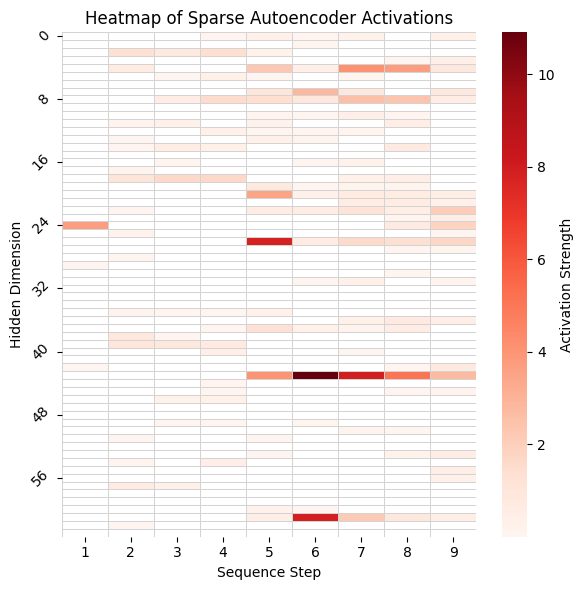

In [85]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_heatmap_sae_activations(
    activation: Float[torch.Tensor, "batch seq d_sae"],
    title: str = "Heatmap of Sparse Autoencoder Activations",
    tokens: list[str] | None = None,
) -> None:

    activations_np = activation[0].detach().cpu().numpy().T

    # Plotting with Seaborn
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(
        activations_np,
        cmap="Reds",
        linewidths=0.5,
        linecolor="lightgrey",
        cbar_kws={"label": "Activation Strength"},
        mask=np.abs(activations_np) < 1e-6,
        square=False,
    )
    plt.title(title)
    plt.ylabel("Hidden Dimension")
    plt.xlabel("Sequence Step")
    plt.yticks(ticks=np.arange(0, 64, 8) + 0.5, labels=np.arange(0, 64, 8), rotation=45)
    plt.xticks(ticks=np.arange(0, 9, 1) + 0.5, labels=np.arange(1, 10, 1), rotation=0)
    plt.tight_layout()
    plt.show()


plot_heatmap_sae_activations(activation)

In [227]:
# now let's go through and do this for all the batches in our SAE
import collections


@dataclasses.dataclass
class TopKActivations:
    activation_indices: Float[torch.Tensor, "seq top_k"]
    activation_values: Float[torch.Tensor, "seq top_k"]


sae_hook_name = "blocks.0.hook_resid_pre"
sae_model = sae_trainer_per_hook[sae_hook_name].sae

# keep the separator token around
separator_token_id = tokenizer.encode("|")[0]

# TODO(bschoen): Super space inefficient
top_k_activations_by_token_string_and_hook_name: dict[str, dict[str, TopKActivations]] = (
    collections.defaultdict(lambda: collections.defaultdict(TopKActivations))
)

for batch_index, batch in tqdm.tqdm(enumerate(train_loader)):

    tokens, _ = batch

    tokens: Float[torch.Tensor, "batch seq"] = tokens.to(device)

    # note: all sequences in a batch are the same length, so we just take the first batch
    #
    # look at the last token, if it's the separator token, skip to the next batch
    #
    # NOTE: This doesn't yet support multiple separators
    while tokens[0, -1] != separator_token_id:

        # otherwise, slice off the last token and run on the shortened string
        tokens = tokens[:, :-1]

        activations_store = ActivationStore()

        # run without gradient
        # run without return type
        with torch.no_grad():
            model.run_with_hooks(
                tokens,
                fwd_hooks=[
                    (
                        sae_hook_name,
                        functools.partial(
                            compute_and_store_sae_activations_hook,
                            sae_model=sae_model,
                            activations_store=activations_store,
                        ),
                    )
                ],
                return_type=None,
            )

        # store everything nicely as strings, this not being vectorized is probably brutal
        for i in range(tokens.shape[0]):
            token_string = tokens_to_string(tokenizer, tokens[i])

            topk_activations = TopKActivations(
                activation_indices=activations_store.activation_indices[i],
                activation_values=activations_store.activation_values[i],
            )

            top_k_activations_by_token_string_and_hook_name[token_string][
                sae_hook_name
            ] = topk_activations

714it [03:51,  3.08it/s]


In [100]:
# note: first break this down into two problems
# 1. for a given token string, which features are activated
# 2. for a given feature, what are the top activating examples
#
# we can do (2) first because we can do auto-interp

len(top_k_activations_by_token_string_and_hook_name)=2048
Token string: <kswh|hks
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] torch.Size([9, 5])
        Feature Values:  [sequence_position, top_k] torch.Size([9, 5])
Token string: <tuvc|ctu
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] torch.Size([9, 5])
        Feature Values:  [sequence_position, top_k] torch.Size([9, 5])
Token string: <oosx|oos
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] torch.Size([9, 5])
        Feature Values:  [sequence_position, top_k] torch.Size([9, 5])
Token string: <emwd|dem
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] torch.Size([9, 5])
        Feature Values:  [sequence_position, top_k] torch.Size([9, 5])
Token string: <lmke|ekl
    Hook name: blocks.0.hook_resid_post
        Feature Indices: [sequence_position, top_k] to

In [232]:
# thank you o1-preview for this truly cursed function
from typing import Dict, Any
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm


def process_activations(
    top_k_activations_by_token_string_and_hook_name: dict[str, dict[str, TopKActivations]],
    max_token_strings: int | None = None,  # useful for testing
) -> pd.DataFrame:
    """
    Processes activations data and returns a DataFrame with the results.

    Parameters:
    - top_k_activations_by_token_string_and_hook_name: A nested dictionary where the first key is the token string,
      the second key is the hook name, and the value is an object containing activation indices and values.

    Returns:
    - all_data: A pandas DataFrame containing the processed data.
    """
    # Initialize lists to collect data
    feature_indices_list: list[np.ndarray] = []
    activation_values_list: list[np.ndarray] = []
    token_string_indices_list: list[np.ndarray] = []
    positions_list: list[np.ndarray] = []
    ks_list: list[np.ndarray] = []
    hook_name_indices_list: list[np.ndarray] = []

    # Dictionaries to map token_strings and hook_names to unique indices
    token_string_to_index: dict[str, int] = {}
    token_strings_list: list[str] = []

    hook_name_to_index: dict[str, int] = {}
    hook_names_list: list[str] = []

    # Loop over your data
    for token_string, hook_name_to_topk_activations in tqdm(
        top_k_activations_by_token_string_and_hook_name.items(),
        desc="Processing tokens",
        leave=False,
    ):

        if max_token_strings is not None and len(token_string_to_index) >= max_token_strings:
            print(f"Reached max_token_strings: {max_token_strings}")
            break

        # Assign a unique index to each unique token_string
        if token_string not in token_string_to_index:
            token_string_index = len(token_strings_list)
            token_strings_list.append(token_string)
            token_string_to_index[token_string] = token_string_index
        else:
            token_string_index = token_string_to_index[token_string]

        for hook_name, topk_activations in hook_name_to_topk_activations.items():
            # Assign a unique index to each unique hook_name
            if hook_name not in hook_name_to_index:
                hook_name_index = len(hook_names_list)
                hook_names_list.append(hook_name)
                hook_name_to_index[hook_name] = hook_name_index
            else:
                hook_name_index = hook_name_to_index[hook_name]

            # Extract activation indices and values
            num_positions, top_k = topk_activations.activation_indices.shape

            # Flatten tensors
            feature_indices = (
                topk_activations.activation_indices.reshape(-1).cpu().numpy().astype(np.int32)
            )
            activation_values = (
                topk_activations.activation_values.reshape(-1).cpu().numpy().astype(np.float32)
            )
            positions = (
                torch.arange(num_positions)
                .unsqueeze(1)
                .repeat(1, top_k)
                .reshape(-1)
                .cpu()
                .numpy()
                .astype(np.int16)
            )
            ks = (
                torch.arange(top_k)
                .unsqueeze(0)
                .repeat(num_positions, 1)
                .reshape(-1)
                .cpu()
                .numpy()
                .astype(np.int8)
            )

            # Create arrays of indices
            token_string_indices = np.full(len(feature_indices), token_string_index, dtype=np.int32)
            hook_name_indices = np.full(len(feature_indices), hook_name_index, dtype=np.int16)

            # Collect data into lists
            feature_indices_list.append(feature_indices)
            activation_values_list.append(activation_values)
            token_string_indices_list.append(token_string_indices)
            positions_list.append(positions)
            ks_list.append(ks)
            hook_name_indices_list.append(hook_name_indices)

    # Debug prints after data collection
    print(f"Data collection complete.")
    print(f"Number of unique token_strings: {len(token_strings_list)}")
    print(f"Number of unique hook_names: {len(hook_names_list)}")
    total_entries = sum(len(arr) for arr in feature_indices_list)
    print(f"Total number of data entries collected: {total_entries}")

    # Concatenate lists into arrays
    print("Concatenating data arrays...")
    feature_indices = np.concatenate(feature_indices_list)
    activation_values = np.concatenate(activation_values_list)
    token_string_indices = np.concatenate(token_string_indices_list)
    positions = np.concatenate(positions_list)
    ks = np.concatenate(ks_list)
    hook_name_indices = np.concatenate(hook_name_indices_list)
    print("Data arrays concatenated.")

    # Debug prints after concatenation
    print(f"Total entries after concatenation: {len(feature_indices)}")
    print(f"Feature indices shape: {feature_indices.shape}")
    print(f"Activation values shape: {activation_values.shape}")

    # Create the DataFrame using the indices
    print("Creating DataFrame...")
    all_data = pd.DataFrame(
        {
            "feature_index": feature_indices,
            "activation_value": activation_values,
            "token_string_index": token_string_indices,
            "hook_name_index": hook_name_indices,
            "position": positions,
            "k": ks,
        }
    )
    print(f"DataFrame created with {len(all_data)} rows.")

    # Map indices back to their respective strings
    print("Creating token_strings DataFrame...")
    token_strings_df = pd.DataFrame(
        {"token_string_index": range(len(token_strings_list)), "token_string": token_strings_list}
    )
    print("Creating hook_names DataFrame...")
    hook_names_df = pd.DataFrame(
        {"hook_name_index": range(len(hook_names_list)), "hook_name": hook_names_list}
    )

    # Merge the mappings into your DataFrame
    print("Merging token_string indices back to strings...")
    all_data = all_data.merge(token_strings_df, on="token_string_index", how="left")
    print("Merging hook_name indices back to strings...")
    all_data = all_data.merge(hook_names_df, on="hook_name_index", how="left")
    print("Merging complete.")

    # Optionally, drop the index columns if you no longer need them
    print("Dropping index columns...")
    all_data.drop(columns=["token_string_index", "hook_name_index"], inplace=True)
    print("Index columns dropped.")

    # Final DataFrame info
    print("Final DataFrame info:")
    print(all_data.info())

    # Optionally, print the first few rows to inspect
    print("First few rows of the DataFrame:")
    print(all_data.head())

    print(f"Processed {len(all_data)} data entries")

    return all_data


all_data = process_activations(top_k_activations_by_token_string_and_hook_name)

Data collection complete.
Number of unique token_strings: 1462272
Number of unique hook_names: 1
Total number of data entries collected: 54835200
Concatenating data arrays...
Data arrays concatenated.
Total entries after concatenation: 54835200
Feature indices shape: (54835200,)
Activation values shape: (54835200,)
Creating DataFrame...
DataFrame created with 54835200 rows.
Creating token_strings DataFrame...
Creating hook_names DataFrame...
Merging token_string indices back to strings...
Merging hook_name indices back to strings...
Merging complete.
Dropping index columns...
Index columns dropped.
Final DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54835200 entries, 0 to 54835199
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   feature_index     int32  
 1   activation_value  float32
 2   position          int16  
 3   k                 int8   
 4   token_string      object 
 5   hook_name         object 
dtypes: fl

In [228]:
import pandas as pd
import numpy as np
import torch
import tqdm


def process_topk_activations(top_k_activations_by_token_string_and_hook_name):
    """
    Processes top-k activations and returns a concatenated DataFrame.

    Args:
        top_k_activations_by_token_string_and_hook_name (dict):
            A nested dictionary where the first key is the token string, the second key is the hook name,
            and the value is an object containing `activation_indices` and `activation_values` tensors.

    Returns:
        pd.DataFrame: A DataFrame containing all processed activation data with the following columns:
            - feature_index (int32)
            - activation_value (float32)
            - token_string (str)
            - position (int16)
            - k (int8)
    """
    data_entries = []

    # Iterate over each token string and its corresponding hooks
    for token_string, hook_name_to_topk_activations in tqdm.tqdm(
        top_k_activations_by_token_string_and_hook_name.items(),
        desc="Processing tokens",
        leave=False,
    ):
        # Iterate over each hook name and its top-k activations
        for hook_name, topk_activations in hook_name_to_topk_activations.items():
            num_positions, top_k = topk_activations.activation_indices.shape

            # Flatten the activation_indices and activation_values tensors
            feature_indices = topk_activations.activation_indices.reshape(-1).cpu().numpy()
            activation_values = topk_activations.activation_values.reshape(-1).cpu().numpy()

            # Generate position indices
            positions = (
                torch.arange(num_positions).unsqueeze(1).repeat(1, top_k).reshape(-1).cpu().numpy()
            )

            # Generate k indices
            ks = torch.arange(top_k).unsqueeze(0).repeat(num_positions, 1).reshape(-1).cpu().numpy()

            # Create a list of the current token string repeated for each activation
            token_strings = [token_string] * len(feature_indices)

            # Create a DataFrame for the current set of activations
            data = pd.DataFrame(
                {
                    "feature_index": feature_indices.astype(np.int32),
                    "activation_value": activation_values.astype(np.float32),
                    "token_string": token_strings,
                    "position": positions.astype(np.int16),
                    "k": ks.astype(np.int8),
                }
            )

            # Append the DataFrame to the list of data entries
            data_entries.append(data)

    # Combine all DataFrames into a single DataFrame
    print(f"Concatenating {len(data_entries)} dataframes...")
    all_data = pd.concat(data_entries, ignore_index=True)
    print(f"Done concatenating {len(data_entries)} dataframes")

    return all_data

Concatenating 1462272 dataframes...


KeyboardInterrupt: 

In [234]:
# Sort and group data to get top N activations per feature
num_top_activations_to_keep_per_feature = 100
top_activations_per_feature = (
    all_data.sort_values(["feature_index", "activation_value"], ascending=[True, False])
    .groupby("feature_index")
    .head(num_top_activations_to_keep_per_feature)
)

In [235]:
all_data["feature_index"].nunique()

60

In [251]:
from termcolor import colored
from IPython.display import display, HTML


# note: with relu we don't have negative activations
def display_top_examples_for_feature(feature_index: int, top_n: int = 10) -> str:
    """
    Returns a string containing the top N examples for the specified feature index.

    Parameters:
    - feature_index (int): The index of the feature to display.
    - top_n (int): The number of top examples to display.

    Returns:
    - str: A formatted string containing the top examples.
    """
    # Filter data for the specified feature
    feature_data = top_activations_per_feature[
        (top_activations_per_feature["feature_index"] == feature_index)
        & (top_activations_per_feature["k"] == 0)
    ]
    feature_data = feature_data.sort_values("activation_value", ascending=False)
    top_examples = feature_data.head(top_n)

    result = [f"Top {top_n} Examples for <feature>{feature_index}</feature>:\n"]

    for idx, row in top_examples.iterrows():
        token_string = row["token_string"]
        position = int(row["position"])

        tokens = list(token_string)

        if 0 <= position < len(tokens):
            token = tokens[position]
            token = f"<token>{token}</token>"
            tokens[position] = token  # colored(token, "red", attrs=["bold"])
        else:
            result.append(
                f"Warning: Position {position} is out of range for token_string '{token_string}'"
            )

        highlighted_token_string = " ".join(tokens)

        result.append(
            f"<activation> {row['activation_value']:.2f} </activation>\t"
            f"<full-string> {highlighted_token_string} </full-string>"
        )

    return "\n".join(result)


# Display top 10 examples for feature index 42
print(display_top_examples_for_feature(58, top_n=10))

Top 10 Examples for <feature>58</feature>:

<activation> 1.29 </activation>	<full-string> < m w <token>f</token> k | f k m </full-string>
<activation> 1.29 </activation>	<full-string> < g q <token>f</token> f | f </full-string>
<activation> 1.29 </activation>	<full-string> < x x <token>f</token> a | a </full-string>
<activation> 1.29 </activation>	<full-string> < l o <token>f</token> z | f </full-string>
<activation> 1.29 </activation>	<full-string> < f w <token>f</token> m | f </full-string>
<activation> 1.29 </activation>	<full-string> < m t <token>f</token> j | f </full-string>
<activation> 1.29 </activation>	<full-string> < y e <token>f</token> s | e </full-string>
<activation> 1.29 </activation>	<full-string> < r q <token>f</token> w | f </full-string>
<activation> 1.29 </activation>	<full-string> < p g <token>f</token> s | f </full-string>
<activation> 1.29 </activation>	<full-string> < k j <token>f</token> v | f </full-string>


In [237]:
def display_top_features_for_token_string(token_string, top_n=5) -> str:
    """
    Generates a string containing the top activating features at each position in the given token_string.

    Parameters:
    - token_string (str): The token string to analyze.
    - top_n (int): The number of top features to display per position.

    Returns:
    - str: A formatted string containing the analysis results.
    """
    from termcolor import colored
    import pandas as pd

    result = []  # List to store all output strings

    # Filter 'all_data' for the given token_string
    data_for_string = all_data[all_data["token_string"] == token_string]

    if data_for_string.empty:
        return f"No activation data available for token_string: '{token_string}'"

    # Ensure 'position' is integer
    data_for_string = data_for_string.copy()
    data_for_string["position"] = data_for_string["position"].astype(int)

    # Get the length of the token_string
    token_length = len(token_string)

    result.append(f"<full-string> {' '.join(token_string)} </full-string>")

    # For each position in the token_string
    for pos in range(token_length):
        # Get the token at current position
        token = token_string[pos]

        # Filter data for the current position
        data_at_position = data_for_string[data_for_string["position"] == pos]

        if data_at_position.empty:
            result.append(f"Position {pos} (Token '{token}'): No activations.")
            continue

        # Get top N features by activation value (descending order)
        top_features = data_at_position.nlargest(top_n, "activation_value")

        # Generate the results
        result.append(f"\n<top-{top_n}-activating-features-at-position>")
        result.append(f"<position>{pos}</position>\n<token>{token}</token>:")
        for idx, row in top_features.iterrows():
            feature_index = int(row["feature_index"])
            activation_value = row["activation_value"]
            k = int(row["k"])
            result.append(
                f"<feature>{feature_index}</feature>\t<activation>{activation_value:.4f}</activation> <k>{k}</k>"
            )
        result.append(f"</top-{top_n}-activating-features-at-position>")

    return "\n".join(result)  # Join all strings with newlines


def display_top_features_for_top_token_string(feature_index: int) -> str:
    """
    Generates a string containing the top activating features at each position for the
    top activating values for a given feature.

    """
    # Filter data for the specified feature
    feature_data = top_activations_per_feature[
        (top_activations_per_feature["feature_index"] == feature_index)
        & (top_activations_per_feature["k"] == 0)
    ]
    feature_data = feature_data.sort_values("activation_value", ascending=False)
    token_string = feature_data["token_string"].values[0]

    return display_top_features_for_token_string(token_string)


print(display_top_features_for_token_string(58, top_n=10))

print(display_top_features_for_top_token_string(58))

No activation data available for token_string: '58'
<full-string> < m w f k | f k m </full-string>

<top-5-activating-features-at-position>
<position>0</position>
<token><</token>:
<feature>19</feature>	<activation>0.7099</activation> <k>0</k>
<feature>29</feature>	<activation>0.2636</activation> <k>1</k>
<feature>0</feature>	<activation>0.0000</activation> <k>2</k>
<feature>1</feature>	<activation>0.0000</activation> <k>3</k>
<feature>2</feature>	<activation>0.0000</activation> <k>4</k>
</top-5-activating-features-at-position>

<top-5-activating-features-at-position>
<position>1</position>
<token>m</token>:
<feature>25</feature>	<activation>1.1649</activation> <k>0</k>
<feature>9</feature>	<activation>0.1280</activation> <k>1</k>
<feature>0</feature>	<activation>0.0000</activation> <k>2</k>
<feature>1</feature>	<activation>0.0000</activation> <k>3</k>
<feature>2</feature>	<activation>0.0000</activation> <k>4</k>
</top-5-activating-features-at-position>

<top-5-activating-features-at-p

#### Feature Frequencies

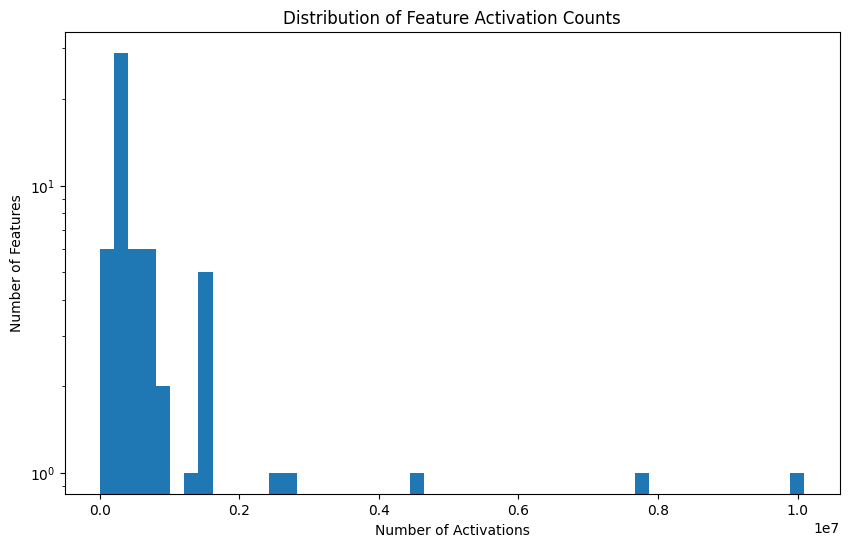

In [238]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'all_data' is your DataFrame containing all activations
# Count the number of times each feature appears
feature_counts = all_data["feature_index"].value_counts().sort_index()

# Convert to a DataFrame
feature_counts_df = feature_counts.reset_index()
feature_counts_df.columns = ["feature_index", "count"]

plt.figure(figsize=(10, 6))
plt.hist(feature_counts_df["count"], bins=50, log=True)
plt.xlabel("Number of Activations")
plt.ylabel("Number of Features")
plt.title("Distribution of Feature Activation Counts")
plt.show()

#### Top Features (by frequency)

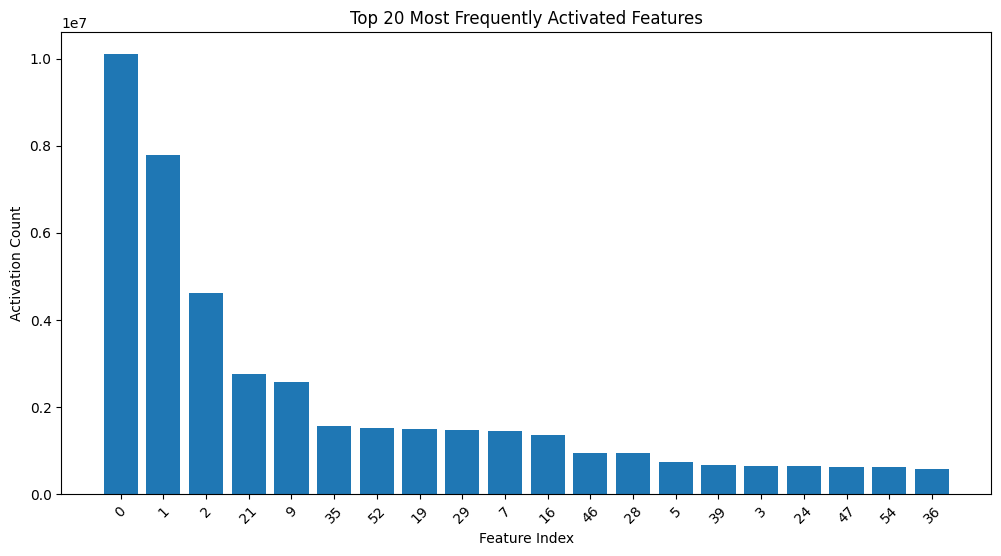

In [239]:
# Get the top N features by frequency
N = 20  # Adjust as needed
top_features = feature_counts_df.nlargest(N, "count")

plt.figure(figsize=(12, 6))

# Note: Converting feature_index to string (astype(str)) ensures proper labeling on the x-axis.
plt.bar(top_features["feature_index"].astype(str), top_features["count"])
plt.xlabel("Feature Index")
plt.ylabel("Activation Count")
plt.title(f"Top {N} Most Frequently Activated Features")
plt.xticks(rotation=45)
plt.show()

#### Feature Activation Values for Specific Feature

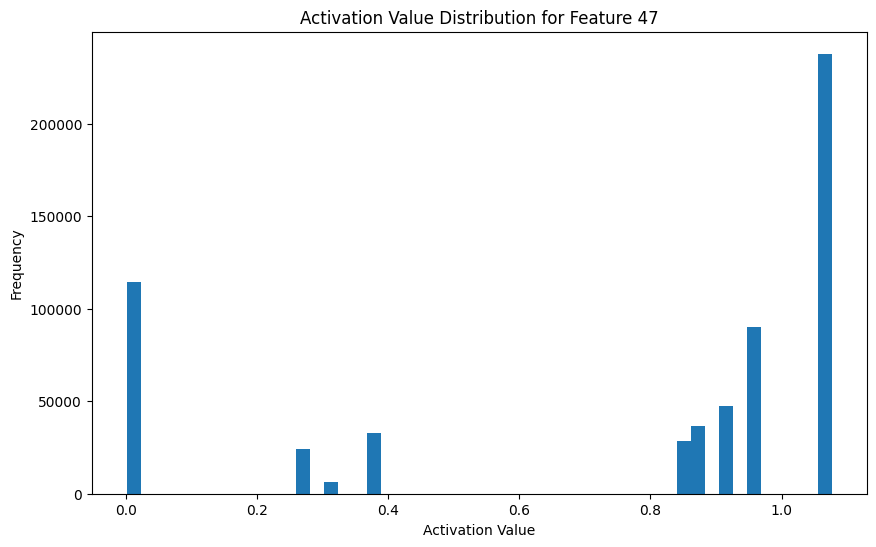

In [241]:
# Example: Plot activation value distribution for a specific feature
feature_index_to_plot = 47  # Replace with the feature index you're interested in
feature_data = all_data[all_data["feature_index"] == feature_index_to_plot]

plt.figure(figsize=(10, 6))
plt.hist(feature_data["activation_value"], bins=50)
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.title(f"Activation Value Distribution for Feature {feature_index_to_plot}")
plt.show()

### Automated Explanations

In [ ]:
# Have the model summarize each example

# TODO(bschoen): Could group different examples together if needed

In [129]:
from neuron_explainer.activations.activation_records import calculate_max_activation
from neuron_explainer.activations.activations import ActivationRecord
from neuron_explainer.explanations.calibrated_simulator import (
    UncalibratedNeuronSimulator,
)
from neuron_explainer.explanations.explainer import (
    HARMONY_V4_MODELS,
    ContextSize,
    TokenActivationPairExplainer,
)
from neuron_explainer.explanations.explanations import ScoredSimulation
from neuron_explainer.explanations.few_shot_examples import FewShotExampleSet
from neuron_explainer.explanations.prompt_builder import PromptFormat
from neuron_explainer.explanations.scoring import (
    _simulate_and_score_sequence,
    aggregate_scored_sequence_simulations,
)
from neuron_explainer.explanations.simulator import (
    LogprobFreeExplanationTokenSimulator,
    NeuronSimulator,
)
from tenacity import retry, stop_after_attempt, wait_random_exponential

In [130]:
ActivationRecord??

Init signature: ActivationRecord(tokens: List[str], activations: List[float]) -> None
Source:        
@register_dataclass
@dataclass
class ActivationRecord(FastDataclass):
    """Collated lists of tokens and their activations for a single neuron."""

    tokens: List[str]
    """Tokens in the text sequence, represented as strings."""
    activations: List[float]
    """Raw activation values for the neuron on each token in the text sequence."""
File:           ~/gpt_from_scratch/venv/lib/python3.12/site-packages/neuron_explainer/activations/activations.py
Type:           type
Subclasses:     

In [242]:
feature_index = 58

top_activations_for_feature = top_activations_per_feature[
    (top_activations_per_feature["feature_index"] == feature_index)
    & (top_activations_per_feature["k"] == 0)
]

activation_min = top_activations_for_feature["activation_value"].min()
activation_max = top_activations_for_feature["activation_value"].max()

# TODO(bschoen): Can give this to model
print(f"Feature {feature_index} activation range: [{activation_min:.2f}, {activation_max:.2f}]")

# sample some so we're not always taking nearly identical strings (this is fine because
# our data is so compact, we likely don't have far spread in activation values
top_activations_for_feature = top_activations_for_feature.sort_values(
    "activation_value", ascending=False
).head(10)

print(len(top_activations_for_feature))

Feature 58 activation range: [1.29, 1.29]
10


In [243]:
top_activations_for_feature

,feature_index,activation_value,position,k,token_string,hook_name
1635,58,1.286841,3,0,<mwfk|fkm,blocks.0.hook_resid_pre
48120,58,1.286841,3,0,<gqff|f,blocks.0.hook_resid_pre
55330,58,1.286841,3,0,<xxfa|a,blocks.0.hook_resid_pre
54210,58,1.286841,3,0,<lofz|f,blocks.0.hook_resid_pre
53195,58,1.286841,3,0,<fwfm|f,blocks.0.hook_resid_pre
52600,58,1.286841,3,0,<mtfj|f,blocks.0.hook_resid_pre
50640,58,1.286841,3,0,<yefs|e,blocks.0.hook_resid_pre
50500,58,1.286841,3,0,<rqfw|f,blocks.0.hook_resid_pre
49835,58,1.286841,3,0,<pgfs|f,blocks.0.hook_resid_pre
48820,58,1.286841,3,0,<kjfv|f,blocks.0.hook_resid_pre


In [244]:
# TODO(bschoen): Could do this with tool use or structured output, but better to be able to do it with o1
def generate_complete_explanation_request_prompt_for_feature(feature_index: int) -> str:
    prompt = rf"""
<task-description>
Generate a human readable explanation for a feature activation in a transformer model that sorts characters in a sequence. The transformer model is given at least the first half of a sequence and must produce the second half in sorted order. Pay especially close attention to anything that could prove your explanation wrong to avoid outputting incorrect explanations!

Please generate an explanation for <feature>{feature_index}</feature>

</task-description>

<max-activating-examples-for-feature>
{display_top_examples_for_feature(feature_index, top_n=10)}
</max-activating-examples-for-feature>

<example-full-string-all-features>
{display_top_features_for_top_token_string(feature_index)}
</example-full-string-all-features>

Remember, your task is generate a very brief, concise, useful explanation for interpreting <feature>{feature_index}</feature> and a score between 0 and 10 for how confident you are in your explanation. 

Please output in the following format:

<explanation-text>EXPLANATION</explanation-text>
<explanation-confidence-score-0-to-10>SCORE</explanation-confidence-score-0-to-10>

"""

    return prompt


print(generate_complete_explanation_request_prompt_for_feature(58))


<task-description>
Generate a human readable explanation for a feature activation in a transformer model that sorts characters in a sequence. The transformerm odel is given at least the first half of a sequence and must produce the second half in sorted order. Pay especially close attention to anything that could prove your explanation wrong to avoid outputting incorrect explanations!

Please generate an explanation for <feature>58</feature>

</task-description>

<max-activating-examples-for-feature>
Top 10 Examples for <feature>58</feature>:

<activation> 1.29 </activation>	<full-string> < m w <token>f</token> k | f k m </full-string>
<activation> 1.29 </activation>	<full-string> < g q <token>f</token> f | f </full-string>
<activation> 1.29 </activation>	<full-string> < x x <token>f</token> a | a </full-string>
<activation> 1.29 </activation>	<full-string> < l o <token>f</token> z | f </full-string>
<activation> 1.29 </activation>	<full-string> < f w <token>f</token> m | f </full-str

In [266]:
from termcolor import colored
from bs4 import BeautifulSoup


def format_text(text):
    """
    Replaces escaped text in angle brackets with colored text.
    """
    # Mapping of tags to colors
    tag_colors = {
        "feature": "blue",
        "activation": "green",
        "token": "red",
        "full-string": "cyan",
        "position": "yellow",
        "top-5-activating-features-at-position": "magenta",
        "k": "white",
        # Add more tags and colors as needed
    }

    # Wrap the text in a root element to make it valid XML
    wrapped_text = f"<root>{text}</root>"

    # Parse the text with BeautifulSoup
    soup = BeautifulSoup(wrapped_text, "html.parser")

    def traverse(element):
        result = ""
        for content in element.contents:
            if isinstance(content, str):
                # Clean up whitespace
                result += content
            else:
                tag = content.name
                color = tag_colors.get(tag, "white")
                inner_text = traverse(content)
                # Apply color to inner text
                colored_text = colored(inner_text.strip(), color)
                result += colored_text
        return result

    formatted_text = traverse(soup)

    # Further formatting for readability
    lines = formatted_text.split("\n")
    formatted_lines = []
    for line in lines:
        # Remove extra spaces and tabs
        line = line.strip()
        if line == "---":
            # Add separator lines
            formatted_lines.append("-" * 40)
        elif line:
            formatted_lines.append(line)
    return "\n".join(formatted_lines)

In [263]:
import re
from jaxtyping import Float, Int
import openai
import tqdm

import tenacity

FeatureIndex = int


@dataclasses.dataclass
class FeatureExplanation:
    text: str
    confidence_score: float | None


def parse_explanation(response_text: str) -> FeatureExplanation:
    """
    Parse the explanation text and confidence score from the API response.

    Expects the response to contain <explanation-text> and <explanation-confidence-score-0-to-10> tags.
    """
    explanation = None
    confidence_score = None

    # Regex patterns to extract the required fields
    explanation_pattern = re.compile(r"<explanation-text>(.*?)<\/explanation-text>", re.DOTALL)
    confidence_pattern = re.compile(
        r"<explanation-confidence-score-0-to-10>(\d+)<\/explanation-confidence-score-0-to-10>"
    )

    explanation_match = explanation_pattern.search(response_text)
    confidence_match = confidence_pattern.search(response_text)

    if explanation_match:
        explanation = explanation_match.group(1).strip()
    else:
        print(f"Warning: <explanation-text> tag not found: {response_text}")

    if confidence_match:
        confidence_score = float(confidence_match.group(1).strip())
    else:
        print(f"Warning: <explanation-confidence-score-0-to-10> tag not found: {response_text}")

    return FeatureExplanation(explanation, confidence_score)


@tenacity.retry(
    wait=tenacity.wait_random_exponential(min=1, max=60),
    stop=tenacity.stop_after_attempt(3),
)
def get_model_generated_feature_explanation(
    client: openai.OpenAI,
    feature_index: int,
) -> FeatureExplanation:

    prompt = generate_complete_explanation_request_prompt_for_feature(feature_index)

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": f"<feature>{feature_index}</feature>"},
        ],
        max_tokens=256,  # TODO(bschoen): Is this way too high?
    )

    # Parse the response
    return parse_explanation(response.choices[0].message.content)


def get_model_generated_feature_explanations(
    client: openai.OpenAI,
    feature_indices: list[FeatureIndex],
) -> dict[FeatureIndex, FeatureExplanation]:
    """Generate explanations for a list of feature indices using the OpenAI API."""
    feature_index_to_explanation: dict[FeatureIndex, FeatureExplanation] = {}

    for feature_index in tqdm.tqdm(feature_indices):

        feature_explanation = get_model_generated_feature_explanation(client, feature_index)

        feature_index_to_explanation[feature_index] = feature_explanation

    return feature_index_to_explanation


# note: not all numbers 0 to 64 are features
#
# also we only use features that have top examples
#
# TODO(bschoen): Which ones are we missing?
feature_indices = sorted(
    top_activations_per_feature[top_activations_per_feature["k"] == 0]["feature_index"]
    .unique()
    .tolist()
)

print(f"{len(feature_indices)=}")

len(feature_indices)=35


In [264]:
client = openai.OpenAI()

feature_explanations = get_model_generated_feature_explanations(client, feature_indices)

100%|██████████| 35/35 [01:57<00:00,  3.35s/it]


In [ ]:
import textwrap

for feature_index, explanation in tqdm.tqdm(feature_explanations.items()):

    print("\n---\n")

    print(f"{feature_index=} - {explanation.confidence_score=}")

    print(f"\n{textwrap.fill(explanation.text, width=100)}\n")

    print(format_text(display_top_examples_for_feature(feature_index, top_n=10)))

    # print("---")

    # print(display_top_features_for_top_token_string(feature_index))

    print("\n---\n")

100%|██████████| 35/35 [00:00<00:00, 935.26it/s]


---

feature_index=0 - explanation.confidence_score=9.0

Feature 0 likely activates when the character 'a' in the second half of the sequence is being
processed. This is evident because all of the top-activating examples for Feature 0 have 'a' as the
first character in the second half of the sequence.


---


---

feature_index=1 - explanation.confidence_score=8.0

Feature 1 is activated when the token 'b' appears in the sequence that needs to be completed or
sorted. This indicates that Feature 1 might be responsible for identifying the occurrence of the
token 'b' as part of the input sequence to assist in completing the sequence in sorted order.


---


---

feature_index=2 - explanation.confidence_score=9.0

Feature 2 appears to be significantly activated when the token 'd' appears in the output sequence,
especially around the sorted part of the sequence. This suggests that Feature 2 might be responsible
for identifying or determining the presence and positioning of the token 'd' in

In [134]:
all_data["token_string"].nunique()

1462272

## Transcoder - Checking Reconstruction

In [ ]:
assert (
    len(test_example_per_difficulty) == 1
), "Here we're assuming only one difficulty, can be easily adapted for more"


print(f"{transcoder_training_cfg.hook_point=}")
print(f"{transcoder_training_cfg.out_hook_point=}")

mlp_in = correct_cache[transcoder_training_cfg.hook_point]
mlp_out = correct_cache[transcoder_training_cfg.out_hook_point]

transcoder_results = mlp_transcoder(mlp_in)

# Print shapes of tensors
print([c for c in correct_string])
print(f"mlp_in: {mlp_in.shape}")
print(f"mlp_out: {mlp_out.shape}")
print(f"transcoder_out: {transcoder_results.transcoder_out.shape}")
print(f"hidden_activations: {transcoder_results.hidden_activations.shape}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

# Assuming you have imported or defined `mlp_in`, `mlp_out`, `transcoder_out`, `hidden_activations`, and `input_tokens_str`


# Function to plot heatmap of activations
def plot_activations(
    activations,
    title,
    xlabel="Neuron",
    ylabel="Sequence Position",
    tokens=None,
    cmap: str = "RdBu",
):
    # Remove batch dimension and convert to numpy
    activations = activations.squeeze(0).detach().cpu().numpy()
    plt.figure(figsize=(4, 2))
    sns.heatmap(activations, cmap=cmap)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if tokens is not None:
        plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=0)
    plt.show()


# 1. Visualize MLP Input Activations (mlp_in)
plot_activations(mlp_in, title="MLP Input Activations", tokens=correct_string)

# 2. Visualize MLP Output Activations (mlp_out)
plot_activations(mlp_out, title="MLP Output Activations", tokens=correct_string)

# 3. Visualize Transcoder Output (transcoder_out)
plot_activations(
    transcoder_results.transcoder_out,
    title="Transcoder Output Activations",
    tokens=correct_string,
)

In [ ]:
def visualize_hidden_activations(hidden_activations, tokens):
    # hidden_activations: [seq_len, hidden_size]
    # tokens: list of token strings

    # Heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        hidden_activations,
        cmap="YlOrRd",
        cbar=True,
        vmin=0,
        vmax=np.max(hidden_activations),
    )
    plt.ylabel("Token Position")
    plt.xlabel("Neuron Index")
    plt.yticks(np.arange(len(tokens)) + 0.5, tokens, rotation=90)
    plt.title("Hidden Activations Heatmap")
    plt.show()

    # Activation Distribution
    activation_values = hidden_activations.flatten()
    plt.figure(figsize=(8, 6))
    plt.hist(activation_values, bins=100, color="blue", alpha=0.7)
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.title("Distribution of Hidden Activations")
    plt.show()

    # PCA
    """from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    activations_pca = pca.fit_transform(hidden_activations)
    plt.figure(figsize=(8, 6))
    plt.scatter(
        activations_pca[:, 0],
        activations_pca[:, 1],
        c=np.arange(len(tokens)),
        cmap="viridis",
    )
    for i, token in enumerate(tokens):
        plt.text(activations_pca[i, 0], activations_pca[i, 1], token)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA of Hidden Activations")
    plt.colorbar(label="Token Position")
    plt.show()"""


visualize_hidden_activations(
    hidden_activations=transcoder_results.hidden_activations[0].detach().cpu().numpy(),
    tokens=incorrect_string,
)

In [ ]:
# 4. Visualize Hidden Activations of MLP (hidden_activations)
# Due to the high dimensionality (2048), we might need to reduce dimensions
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2 for visualization
activations = transcoder_results.hidden_activations.squeeze(0).detach().cpu().numpy()
pca = PCA(n_components=2)
reduced_activations = pca.fit_transform(activations.reshape(-1, activations.shape[-1]))

# Plot the PCA-reduced activations
plt.figure(figsize=(4, 2))
scatter = plt.scatter(
    reduced_activations[:, 0],
    reduced_activations[:, 1],
    c=np.arange(activations.shape[0]),
    cmap="viridis",
)
plt.colorbar(scatter, label="Sequence Position")
plt.title("PCA of Hidden Activations")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Alternatively, plot a subset of neurons
num_neurons_to_plot = 2048  # Adjust based on preference
selected_neurons = activations[:, :num_neurons_to_plot]

plot_activations(
    torch.tensor(selected_neurons),
    title="Hidden Activations (First {} Neurons)".format(num_neurons_to_plot),
    xlabel="Neuron",
    tokens=input_tokens_str,
    cmap="grey",
)

In [ ]:
# 5. Visualize Distributions of Activations
def plot_activation_distribution(activations, title):
    activations = activations.detach().cpu().numpy().flatten()
    plt.figure(figsize=(4, 3))
    sns.histplot(activations, bins=100, kde=True)
    plt.title(title)
    plt.xlabel("Activation Value")
    plt.ylabel("Frequency")
    plt.show()


plot_activation_distribution(mlp_in, title="Distribution of MLP Input Activations")

plot_activation_distribution(mlp_out, title="Distribution of MLP Output Activations")

plot_activation_distribution(
    transcoder_results.hidden_activations,
    title="Distribution of Hidden Activations",
)

In [ ]:
mlp = model.blocks[1].mlp

In [ ]:
mlp.W_out

In [ ]:
# 6. Visualize MLP Weights
# Assuming you have access to the MLP model
# Replace `model` with your transformer model variable and adjust layer indices accordingly

# Visualize weights of the first linear layer
weight_matrix = model.blocks[0].mlp.W_in.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(weight_matrix, cmap="coolwarm", center=0)
plt.title("Weights of MLP Layer fc1")
plt.xlabel("Input Neuron")
plt.ylabel("Output Neuron")
plt.show()

# Visualize weights of the second linear layer
weight_matrix = model.blocks[1].mlp.W_in.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(weight_matrix, cmap="coolwarm", center=0)
plt.title("Weights of MLP Layer fc2")
plt.xlabel("Input Neuron")
plt.ylabel("Output Neuron")
plt.show()

## Optuna Study

In [ ]:
import optuna


# TODO(bschoen): Do need to use lightning if want to do this generally
# note: generally do want to iterate on this part itself, i.e. once find promising learning rate, searching other hyperparameters
def objective(trial: optuna.Trial) -> float:

    # TODO(bschoen): up to one per position, eh might as well try it

    d_model = trial.suggest_categorical("d_model", [8, 16, 32, 64, 128])
    n_heads = trial.suggest_int("n_heads", 1, 8)

    cfg = ModelAndTrainingConfig(
        num_epochs=1000,
        eval_test_every_n=10000,  # not worth evaluating test loss for study
        n_layers=1,  # trial.suggest_int("n_layers", 1, 2),
        d_model=d_model,
        n_heads=n_heads,
        learning_rate=5e-4,
    )

    # sanity check `d_heads`
    if (cfg.d_model % cfg.n_heads) != 0:
        print(f"Pruning trial for {cfg.d_model=} {cfg.n_heads=}")
        raise optuna.exceptions.TrialPruned()

    result = train_model(cfg)

    return result.train_loss


enable_optuna = False

if enable_optuna:

    study_storage_url = "sqlite:///toy-problem-hooked-transformer.db"

    study = optuna.create_study(
        directions=[optuna.study.StudyDirection.MINIMIZE],
        storage=study_storage_url,
    )

    study.optimize(objective, n_trials=10)

    print("View by launching optuna dashboard from the command line:")
    print(f"optuna-dashboard {study_storage_url}")

    # now let's do a real run
    training_config = ModelAndTrainingConfig(
        num_epochs=10000,
        eval_test_every_n=1000,
        n_layers=1,
        d_model=16,
        n_heads=1,
    )

    result = train_model(cfg=training_config)

    # for compatibility with code later
    model = result.model
    cfg = training_config.get_hooked_transformer_config()

In [ ]:
# Look at some example output
import circuitsvis as cv

import functools


def visualize_pattern_hook(
    pattern: Float32[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: transformer_lens.hook_points.HookPoint,
    tokens_as_strings: list[str],
) -> None:
    print(f"Batch size: {pattern.shape[0]}")
    print("Layer: ", hook.layer())
    display(cv.attention.attention_patterns(tokens=tokens_as_strings, attention=pattern.mean(0)))


test_input_string_to_cache = {}

for difficulty, test_loader in test_loaders.items():

    print(difficulty)

    # grab something from the test batch
    example_batch = next(iter(test_loader))

    x, y = example_batch

    example_sample = x[0]

    # example_sample = torch.tensor(tokenizer.encode("<az|za|az>>>>>>>>>>"))

    # grab the first part of it, ex: `<abc|`
    example_prompt = example_sample  # [:8]

    example_prompt = example_prompt.to(device)

    print(f"Using {example_prompt} from {example_sample} (from test set)")

    # note: already encoded
    input_tokens = example_prompt

    # first let's get these as strings so can easily work with them
    input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

    # wrap to bind input tokens
    visualize_pattern_hook_fn = functools.partial(
        visualize_pattern_hook, tokens_as_strings=input_tokens_as_strings
    )

    model.run_with_hooks(
        input_tokens,
        return_type=None,  # For efficiency, we don't need to calculate the logits
        fwd_hooks=[(lambda name: name.endswith("pattern"), visualize_pattern_hook_fn)],
    )

    logits_batch, cache = model.run_with_cache(input_tokens)

    # store so can plot together later
    test_input_string_to_cache["".join(input_tokens_as_strings)] = cache

    logits = logits_batch[0]

    log_probs = logits.log_softmax(dim=-1)

    cv.logits.token_log_probs(
        token_indices=input_tokens,
        log_probs=log_probs,
        to_string=token_to_string,
    )

In [ ]:
cache.apply_ln_to_stack?

In [ ]:
cache.stack_head_results??

In [ ]:
import transformer_lens.patching

transformer_lens.patching.get_act_patch_resid_pre??

In [ ]:
import einops


def logit_attribution(
    embed: Float32[torch.Tensor, "seq d_model"],
    l1_results: Float32[torch.Tensor, "seq nheads d_model"],
    l2_results: Float32[torch.Tensor, "seq nheads d_model"],
    W_U: Float32[torch.Tensor, "d_model d_vocab"],
    tokens: Int64[torch.Tensor, "seq"],
) -> Float32[torch.Tensor, "seq-1 n_components"]:
    """
    Inputs:
        embed: the embeddings of the tokens (i.e. token + position embeddings)
        l1_results: the outputs of the attention heads at layer 1 (with head as one of the dimensions)
        l2_results: the outputs of the attention heads at layer 2 (with head as one of the dimensions)
        W_U: the unembedding matrix
        tokens: the token ids of the sequence

    Returns:
        Tensor of shape (seq_len-1, n_components)
        represents the concatenation (along dim=-1) of logit attributions from:
            the direct path (seq-1,1)
            layer 0 logits (seq-1, n_heads)
            layer 1 logits (seq-1, n_heads)
        so n_components = 1 + 2*n_heads
    """
    W_U_correct_tokens = W_U[:, tokens[1:]]
    # SOLUTION
    direct_attributions = einops.einsum(W_U_correct_tokens, embed[:-1], "emb seq, seq emb -> seq")
    l1_attributions = einops.einsum(
        W_U_correct_tokens, l1_results[:-1], "emb seq, seq nhead emb -> seq nhead"
    )
    l2_attributions = einops.einsum(
        W_U_correct_tokens, l2_results[:-1], "emb seq, seq nhead emb -> seq nhead"
    )
    return torch.concat(
        [direct_attributions.unsqueeze(-1), l1_attributions, l2_attributions], dim=-1
    )


logits, cache = model.run_with_cache(input_tokens, remove_batch_dim=True)
str_tokens = input_tokens_as_strings
tokens = input_tokens

with t.inference_mode():
    embed = cache["embed"]
    l1_results = cache["result", 0]
    l2_results = cache["result", 1]
    logit_attr = logit_attribution(
        embed,
        l1_results,
        l2_results,
        model.W_U,
        tokens[0],
    )

    # Uses fancy indexing to get a len(tokens[0])-1 length tensor, where the kth entry is the predicted logit for the correct k+1th token
    correct_token_logits = logits[0, torch.arange(len(tokens[0]) - 1), tokens[0, 1:]]

## Looking at it with CircuitsViz

In [ ]:
# before even going to SAE, let's look at circuitsviz here
import circuitsvis as cv

import circuitsvis.activations
import circuitsvis.attention
import circuitsvis.logits
import circuitsvis.tokens
import circuitsvis.topk_samples
import circuitsvis.topk_tokens

In [ ]:
# first let's see what we have
import tabulate

print(f"{len(input_tokens)=}")

# show the first few elements of the `HookedTransformerConfig`, since that has things like `d_model`, num heads, etc
print(tabulate.tabulate([(k, v) for k, v in cfg.__dict__.items()][:10]))

print(tabulate.tabulate([(k, v.shape) for k, v in cache.items()]))

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Viridis256

import numpy as np
import pandas as pd

from bokeh.io import output_notebook

import seaborn as sns

import matplotlib.pyplot as plt

# Enable Bokeh output in the notebook
output_notebook()


def tensor_to_dataframe(tensor: torch.Tensor, labels: list[str], tokens: list[str]) -> pd.DataFrame:
    """
    Convert a 2D PyTorch tensor to a pandas DataFrame.

    Args:
        tensor (torch.Tensor): A 2D tensor to convert.

    Returns:
        pd.DataFrame: A DataFrame representation of the input tensor.

    Raises:
        ValueError: If the input tensor is not 2D.
    """
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.dim()}D")
    if len(labels) != 2:
        raise ValueError(f"Expected labels for both dimensions, got {len(labels)}")

    # Convert tensor to numpy array
    numpy_array = tensor.detach().cpu().numpy()

    # Create DataFrame
    df = pd.DataFrame(numpy_array)

    # Name the index the first label
    df.index.name = labels[0]

    # Name the columns the second label
    df.columns = [f"{labels[1]}_{i}" for i in range(numpy_array.shape[1])]

    return df


def visualize_tensor_heatmap(
    tensor: torch.Tensor,
    title: str = "Tensor Heatmap",
    colormap: list[str] = Viridis256,
    width: int = 800,
    height: int = 400,
) -> None:
    """
    Visualize a 2D tensor as a heatmap.

    Args:
        tensor (torch.Tensor): A 2D tensor to visualize.
        title (str): Title of the heatmap.
        colormap (List[str]): A list of colors to use for the heatmap.
        width (int): Width of the plot in pixels.
        height (int): Height of the plot in pixels.

    """

    # Ensure tensor is 2D
    if tensor.dim() != 2:
        raise ValueError(f"Input tensor must be 2D, got {tensor.shape}")

    # convert tensor to dataframe
    df = tensor_to_dataframe(tensor)

    # Create a 2D grid of coordinates
    y, x = np.mgrid[0 : data.shape[0], 0 : data.shape[1]]

    # Flatten the arrays
    x = x.flatten()
    y = y.flatten()
    z = data.flatten()

    # Create a ColumnDataSource
    source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            z=z,
            color=Viridis256[:: int(256 / len(z))][: len(z)],  # Map values to colors
        )
    )

    # Create the figure
    p = figure(
        title="Tensor Heatmap",
        x_range=(0, data.shape[1]),
        y_range=(0, data.shape[0]),
        toolbar_location="below",
        tools="pan,wheel_zoom,box_zoom,reset",
    )

    # Add rectangular glyphs
    p.rect(
        x="x",
        y="y",
        width=1,
        height=1,
        source=source,
        fill_color="color",
        line_color=None,
    )

    # Add hover tool
    hover = HoverTool(tooltips=[("x", "@x"), ("y", "@y"), ("value", "@z{0.000}")])
    p.add_tools(hover)

    # Invert y-axis to match tensor indexing
    p.y_range.start, p.y_range.end = p.y_range.end, p.y_range.start

    # Show the plot
    show(p)

In [ ]:
print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

In [ ]:
# let's go ahead and just use first batch
def first_batch(tensor: Float32[torch.Tensor, "b t c"]) -> Float32[torch.Tensor, "t c"]:
    return tensor[0]

In [ ]:
model

In [ ]:
import torch.nn as nn

from typing import Iterable, TypeVar

import tabulate

T = TypeVar("T")


# alias for `print(tabulate.tabulate(data))`
def print_table(data: T) -> None:
    print(tabulate.tabulate(data))


# Define a function to print module weights recursively
def print_module_weights(module: nn.Module) -> Iterable[tuple[str, str]]:
    """
    Recursively prints the weights of a PyTorch module and its submodules.

    This function traverses through the module hierarchy, printing information
    about parameters that require gradients and are not hook-related.

    Example:
        >>> print_table(print_module_weights(model))

        ------------------  ----------------------
        embed.W_E           torch.Size([29, 14])
        pos_embed.W_pos     torch.Size([9, 14])
        blocks.0.ln1.w      torch.Size([14])
        blocks.0.ln1.b      torch.Size([14])
        blocks.0.ln2.w      torch.Size([14])
        blocks.0.ln2.b      torch.Size([14])
        blocks.0.attn.W_Q   torch.Size([3, 14, 4])
        blocks.0.attn.W_O   torch.Size([3, 4, 14])
        blocks.0.attn.b_Q   torch.Size([3, 4])
        blocks.0.attn.b_O   torch.Size([14])
        blocks.0.attn.W_K   torch.Size([3, 14, 4])
        blocks.0.attn.W_V   torch.Size([3, 14, 4])
        blocks.0.attn.b_K   torch.Size([3, 4])
        blocks.0.attn.b_V   torch.Size([3, 4])
        blocks.0.mlp.W_in   torch.Size([14, 56])
        blocks.0.mlp.b_in   torch.Size([56])
        blocks.0.mlp.W_out  torch.Size([56, 14])
        blocks.0.mlp.b_out  torch.Size([14])
        ln_final.w          torch.Size([14])
        ln_final.b          torch.Size([14])
        unembed.W_U         torch.Size([14, 29])
        unembed.b_U         torch.Size([29])
        ------------------  ----------------------

    Args:
        module (nn.Module): The PyTorch module to inspect.
        prefix (str, optional): A string prefix for indentation in the output.
                                Defaults to an empty string.

    Returns:
        Iterable[tuple[str, str]]: A list of tuples, where each tuple contains
            the name and shape of the parameter.
    """

    # Iterate through named parameters of the module
    for name, param in module.named_parameters():

        # Check if parameter requires gradient and doesn't start with 'hook_'
        if param.requires_grad and not name.startswith("hook_"):

            # yield parameter name and type
            yield f"{name}", f"{param.shape}"


def print_cache(cache: transformer_lens.ActivationCache) -> None:
    print(tabulate.tabulate([(k, v[0].shape) for k, v in cache.items()]))

In [ ]:
print("Weights in the model:")
print_table(print_module_weights(model))

In [ ]:
print("Cached activations:")
print_cache(cache)

In [ ]:
def plot_cache_activation(
    cache: transformer_lens.ActivationCache,
    cache_key: str,
    input_tokens_as_strings: list[str],
) -> None:

    activations = first_batch(cache[cache_key])

    figsize = (4, 4)

    # make figure smaller for vectors
    if activations.shape[-1] == 1:
        figsize = (4, 1.5)

    # for larger activations like MLP, allow it to be taller
    elif activations.shape[-1] > 20:
        figsize = (4, 12)

    plt.figure(figsize=figsize)

    sns.heatmap(
        activations.cpu().numpy().T,
        cmap="coolwarm",
        center=0,
        xticklabels=input_tokens_as_strings,
    )

    plt.title(cache_key)

    # TODO(bschoen): Allow specifying this
    #
    plt.ylabel("Embedding Dimension")
    plt.xlabel("Token")

    plt.tight_layout()
    plt.show()


for cache_key in [
    "hook_embed",
    "hook_pos_embed",
    "blocks.0.hook_resid_pre",
    "blocks.0.ln1.hook_scale",
    "blocks.0.ln1.hook_normalized",
    "blocks.0.hook_attn_out",
    "blocks.0.hook_resid_mid",
    "blocks.0.ln2.hook_scale",
    "blocks.0.ln2.hook_normalized",
    "blocks.0.mlp.hook_pre",
    "blocks.0.mlp.hook_post",
    "blocks.0.hook_mlp_out",
    "blocks.0.hook_resid_post",
    "ln_final.hook_scale",
    "ln_final.hook_normalized",
]:

    plot_cache_activation(
        cache=cache,
        cache_key=cache_key,
        input_tokens_as_strings=input_tokens_as_strings,
    )

In [ ]:
# visualize MLP

import matplotlib.pyplot as plt
import seaborn as sns
import torch


def plot_mlp_weights_and_biases(model):
    # Function to plot heatmaps for MLP weights and biases

    def plot_weight_bias_pair(weight, bias, title):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        sns.heatmap(weight.detach().cpu().numpy(), ax=ax1, cmap="coolwarm", center=0)
        ax1.set_title(f"{title} - Weights")
        ax1.set_xlabel("Output dimension")
        ax1.set_ylabel("Input dimension")

        sns.heatmap(
            bias.detach().cpu().numpy().reshape(-1, 1),
            ax=ax2,
            cmap="coolwarm",
            center=0,
        )
        ax2.set_title(f"{title} - Biases")
        ax2.set_xlabel("Bias")
        ax2.set_ylabel("Dimension")

        plt.tight_layout()
        plt.show()

    # MLP weights and biases
    plot_weight_bias_pair(model.blocks[0].mlp.W_in, model.blocks[0].mlp.b_in, "MLP Input")
    plot_weight_bias_pair(model.blocks[0].mlp.W_out, model.blocks[0].mlp.b_out, "MLP Output")

    # Layer Norm final
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(
        model.ln_final.w.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=1,
    )
    plt.title("Layer Norm Final - Weights")
    plt.subplot(1, 2, 2)
    sns.heatmap(
        model.ln_final.b.detach().cpu().numpy().reshape(1, -1),
        cmap="coolwarm",
        center=0,
    )
    plt.title("Layer Norm Final - Biases")
    plt.tight_layout()
    plt.show()

    # Unembed
    plot_weight_bias_pair(model.unembed.W_U, model.unembed.b_U, "Unembed")


# Call the function
plot_mlp_weights_and_biases(model)

# Comment: Additional visualizations that could be useful:
# 1. Histograms of weight/bias distributions
# 2. 3D surface plots for weights to show patterns
# 3. Network architecture diagram with weight magnitudes represented by line thickness
# 4. Animated heatmaps showing weight changes during training

In [ ]:
def plot_weight_bias_activation(
    weight,
    bias,
    activation,
    title: str,
) -> None:

    activation = first_batch(activation)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    sns.heatmap(weight.detach().cpu().numpy().T, ax=ax1, cmap="coolwarm", center=0)
    ax1.set_title(f"{title} - Weight")

    sns.barplot(x=list(range(len(bias))), y=bias.detach().cpu().numpy(), ax=ax2)
    ax2.set_title(f"{title} - Bias")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Value")

    sns.heatmap(activation.detach().cpu().numpy().T, ax=ax3, cmap="coolwarm", center=0)
    ax3.set_title(f"{title} - Activation")

    plt.tight_layout()
    plt.show()


plot_weight_bias_activation(
    model.embed.W_E,
    torch.zeros(model.embed.W_E.shape[1]),
    cache["hook_embed"],
    "Embedding",
)
plot_weight_bias_activation(
    model.pos_embed.W_pos,
    torch.zeros(model.pos_embed.W_pos.shape[1]),
    cache["hook_pos_embed"],
    "Positional Embedding",
)

In [ ]:
# TODO(bschoen): Hook residual pre?

In [ ]:
# Plotting LayerNorm components


def plot_layernorm(scale, normalized, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    scale = first_batch(scale)
    normalized = first_batch(normalized)

    sns.barplot(x=list(range(len(scale))), y=scale.squeeze().detach().cpu().numpy(), ax=ax1)
    ax1.set_title(f"{title} - Scale")
    ax1.set_xlabel("Index")
    ax1.set_ylabel("Value")

    sns.heatmap(normalized.detach().cpu().numpy().T, ax=ax2, cmap="coolwarm", center=0)
    ax2.set_title(f"{title} - Normalized")

    plt.tight_layout()
    plt.show()


plot_layernorm(
    cache["blocks.0.ln1.hook_scale"],
    cache["blocks.0.ln1.hook_normalized"],
    "LayerNorm 1",
)

In [ ]:
# Plotting MLP components
plot_weight_bias_activation(
    model.blocks[0].mlp.W_in,
    model.blocks[0].mlp.b_in,
    cache["blocks.0.mlp.hook_pre"],
    "MLP Input",
)
plot_weight_bias_activation(
    model.blocks[0].mlp.W_out,
    model.blocks[0].mlp.b_out,
    cache["blocks.0.mlp.hook_post"],
    "MLP Output",
)

#### circuitsvis.activations

In [ ]:
# tokens := List of tokens if single sample (e.g. `["A", "person"]`) or list of lists of tokens (e.g. `[[["A", "person"], ["is", "walking"]]]`)
# activations := Activations of the shape [tokens x layers x neurons] if single sample or list of [tokens x layers x neurons] if multiple samples

# take first batch for now
activations = cache["blocks.0.hook_mlp_out"][0]
print(f"{activations.shape=}")

# reshape [tokens x neurons] -> [tokens x 1 x neurons]
#  - `-1` means to automatically infer the size of the last dimension
activations_view = activations.view(len(input_tokens), cfg.n_layers, -1)

print(f"{activations_view.shape=}")

# convert to strings (which this function expects)
input_tokens_as_strings = [token_to_string(x.item()) for x in input_tokens]

# TODO(bschoen): Is there a way to essentially stack these? Claude can probably give the React for that

# so here we can visualize activations for a `torch.Size([1, 8, 16])`, which is most
# of them since this is the size of the embedding dimension
circuitsvis.activations.text_neuron_activations(
    tokens=[token_to_string(x.item()) for x in input_tokens],
    activations=activations_view,
)

#### circuitsvis.attention

In [ ]:
# tokens: List of tokens (e.g. `["A", "person"]`). Must be the same length as the list of values.
# attention: Attention head activations of the shape [dest_tokens x src_tokens]
# max_value: Maximum value. Used to determine how dark the token color is when positive (i.e. based on how close it is to the maximum value).
# min_value: Minimum value. Used to determine how dark the token color is when negative (i.e. based on how close it is to the minimum value).
# negative_color: Color for negative values
# positive_color: Color for positive values.
# show_axis_labels: Whether to show axis labels.
# mask_upper_tri: Whether or not to mask the upper triangular portion of the attention patterns. Should be true for causal attention, false for bidirectional attention.


# take first batch
# ex: torch.Size([4, 8, 8]) -> [n_heads, n_ctx, n_ctx]
# note: `blocks.0.attn.hook_attn_scores` is too early (not normalized?)
attention = cache["blocks.0.attn.hook_pattern"][0]

print(f"{attention.shape=}")

circuitsvis.attention.attention_heads(
    tokens=input_tokens_as_strings,
    attention=attention,
    max_value=1,
    min_value=-1,
    negative_color="blue",
    positive_color="red",
    mask_upper_tri=True,
)

#### circuitsvis.logits

In [ ]:
# this is the normal one we usually show, i.e.
# cv.logits.token_log_probs(
#     token_indices=input_tokens,
#     log_probs=log_probs,
#     to_string=token_to_string,
# )

#### circuitsvis.tokens

In [ ]:
# for example, we'll look at each

# take first batch, ex: torch.Size([8, 16])
pos_embed = cache["hook_pos_embed"][0]

# low level function for coloring tokens according to single value
for i in range(cfg.d_model):
    display(
        circuitsvis.tokens.colored_tokens(
            tokens=input_tokens_as_strings,
            values=pos_embed[:, i],
            negative_color="blue",
            positive_color="red",
        )
    )

    # only display a few for example
    # if i >= 2:
    #    break

In [ ]:
# take first batch
# ex: torch.size([8, 16]) = [n_ctx, d_model]
attention_out = cache["blocks.0.hook_attn_out"][0]

circuitsvis.tokens.colored_tokens_multi(
    tokens=input_tokens_as_strings,
    values=attention_out,
    labels=[str(x) for x in range(cfg.d_model)],
)

In [ ]:
circuitsvis.tokens.visualize_model_performance(
    tokens=input_tokens,
    str_tokens=input_tokens_as_strings,
    logits=logits,
)

#### circuitsvis.topk_samples

In [ ]:
circuitsvis.topk_samples.topk_samples??

#### circuitsvis.topk_tokens

In [ ]:
circuitsvis.topk_tokens.topk_tokens??

## SAE (old)

In [ ]:
for layer_index in range(cfg.n_layers):
    imshow(
        transformer_lens.utils.to_numpy(cache["attn", layer_index].mean([0, 1])),
        title=f"Layer {layer_index} Attention Pattern",
        height=400,
        width=400,
    )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dataclasses

Loss = Float32[torch.Tensor, ""]
MSELoss = Float32[torch.Tensor, ""]
WeightedSparsityLoss = Float32[torch.Tensor, ""]

Logits = Float32[torch.Tensor, "n_ctx d_vocab"]
BatchedLogits = Float32[torch.Tensor, "batch n_ctx d_vocab"]

ModelActivations = Float32[torch.Tensor, "n_ctx d_model"]
BatchedModelActivations = Float32[torch.Tensor, "batch n_ctx d_model"]

FlattenedModelActivations = Float32[torch.Tensor, "d_sae_in"]

BatchedFlattenedModelActivations = Float32[torch.Tensor, "batch d_sae_in"]
BatchedSAEActivations = Float32[torch.Tensor, "batch d_sae_model"]


@dataclasses.dataclass
class SAEOutput:
    sae_activations: BatchedSAEActivations
    reconstructed_model_activations: BatchedFlattenedModelActivations


def sparse_loss_kl_divergence(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_target: float,
    sparsity_weight: float,
    epsilon: float = 1e-7,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # same as dense loss (this is constant?)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # KL divergence for sparsity
    avg_activation = torch.mean(sae_output.sae_activations, dim=0)

    # print(f'[pre-clamping] {avg_activation=}')

    # Add epsilon for numerical stability
    avg_activation = torch.clamp(avg_activation, epsilon, 1 - epsilon)

    kl_div = sparsity_target * torch.log(sparsity_target / avg_activation) + (
        1 - sparsity_target
    ) * torch.log((1 - sparsity_target) / (1 - avg_activation))
    kl_div = torch.sum(kl_div)

    # `sparsity_weight` decides how much we weight `KL-Divergence`
    sparsity_penalty = sparsity_weight * kl_div

    # print(f"{mse_loss=}, {avg_activation=}, {kl_div.item()}, {sparsity_penalty=}")

    return mse_loss + sparsity_penalty, mse_loss, sparsity_penalty

In [ ]:
def sparse_loss_l1_norm(
    flattened_model_activations: BatchedFlattenedModelActivations,
    sae_output: SAEOutput,
    sparsity_weight: float,
) -> tuple[Loss, MSELoss, WeightedSparsityLoss]:

    # Reconstruction loss (Mean Squared Error)
    mse_loss = F.mse_loss(
        sae_output.reconstructed_model_activations,
        flattened_model_activations,
    )

    # L1 sparsity penalty
    l1_penalty = torch.mean(torch.abs(sae_output.sae_activations))

    sparsity_penalty = sparsity_weight * l1_penalty

    # Total loss
    total_loss = mse_loss + sparsity_penalty

    return total_loss, mse_loss, sparsity_penalty

In [ ]:
import dataclasses


@dataclasses.dataclass
class SparseAutoencoderConfig:
    d_in: int
    d_model: int


# TODO(bschoen): Start using the config pattern, it stays typesafe and allows
#                easy logging to things like wandb
class SparseAutoencoder(nn.Module):
    def __init__(
        self,
        cfg: SparseAutoencoderConfig,
    ) -> None:

        print(f"Creating SparseAutoencoder with {cfg}")

        super(SparseAutoencoder, self).__init__()

        self.d_in = cfg.d_in
        self.d_model = cfg.d_model

        self.encoder = nn.Linear(cfg.d_in, cfg.d_model)
        self.decoder = nn.Linear(cfg.d_model, cfg.d_in)

    def forward(
        self,
        x: BatchedFlattenedModelActivations,
    ) -> SAEOutput:

        # TODO(bschoen): Which activation function should we use?
        encoded = F.gelu(self.encoder(x))

        decoded = self.decoder(encoded)

        return SAEOutput(
            sae_activations=encoded,
            reconstructed_model_activations=decoded,
        )

In [ ]:
import lightning.pytorch


@dataclasses.dataclass
class LightningSparseAutoencoderConfig:

    model_config: transformer_lens.HookedTransformerConfig
    sae_config: SparseAutoencoderConfig
    learning_rate: float
    sparsity_weight: float


# note: this kind of lightning adapter is a common pattern: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html#starter-example
class LightningSparseAutoencoder(lightning.pytorch.LightningModule):
    def __init__(
        self,
        cfg: LightningSparseAutoencoderConfig,
    ) -> None:

        super(LightningSparseAutoencoder, self).__init__()

        self.model = transformer_lens.HookedTransformer(cfg=cfg.model_config)
        self.sae = SparseAutoencoder(cfg=cfg.sae_config)
        self.cfg = cfg

    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx: int) -> Loss:
        inputs, target = batch

        self.model
        output = self(inputs, target)
        loss = torch.nn.functional.cr(output, target.view(-1))
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [ ]:
hook_id = "blocks.0.hook_mlp_out"

cache[hook_id].shape

In [ ]:
# Training loop
sae_num_epochs = 100000
sae_expansion_factor = 64

learning_rate = 5e-4

# both arbitrary for now
# - Start small: A common approach is to begin with a relatively small sparsity weight,
#                typically in the range of 1e-5 to 1e-3. This allows the model to
#                learn meaningful representations before enforcing strong sparsity
#                constraints.
sparsity_weight: float = 1e-3  # Weight of the sparsity loss in the total loss
sparsity_target: float = 0.05  # Target average activation of hidden neurons

print(f"Training SAE for {hook_id}...")
sae_d_in = (cfg.n_ctx - 1) * cfg.d_model  # -1 since not predicting first token
sae_d_model = sae_d_in * sae_expansion_factor

sae_cfg = SparseAutoencoderConfig(
    d_in=sae_d_in,
    d_model=sae_d_model,
)

sae_model = SparseAutoencoder(cfg=sae_cfg)
sae_model.to(device)

sae_optimizer = optim.Adam(sae_model.parameters(), lr=learning_rate)

wandb.init(
    project="toy-problem-hooked-transformer-sae",
    config={
        "sae_num_epochs": sae_num_epochs,
        "sae_expansion_factor": sae_expansion_factor,
        "learning_rate": learning_rate,
        "sparsity_weight": sparsity_weight,
        "sparsity_target": sparsity_target,
        "sae_d_in": sae_d_in,
        "sae_d_model": sae_d_model,
        "hook_id": hook_id,
    },
)

# put model itself into eval mode so doesn't change
model.eval()

# go through the training data again, this time training the sae on the activations
for epoch, batch in tqdm.tqdm(
    zip(
        range(sae_num_epochs),
        itertools.cycle(train_loader),
    )
):

    tokens, target = batch

    tokens, target = tokens.to(device), target.to(device)

    # run through the model (with cache) to get the activations
    logits, cache = model.run_with_cache(tokens)

    # ex: torch.Size([4, 8, 16])
    activations = cache[hook_id]

    # ex: torch.Size([4, 128])
    flattened_activations = activations.reshape(activations.size(0), -1)

    sae_optimizer.zero_grad()

    # now the SAE model is given the *activations*
    sae_output = sae_model.forward(flattened_activations)

    # compute loss

    total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_kl_divergence(
        flattened_activations,
        sae_output,
        sparsity_target=sparsity_target,
        sparsity_weight=sparsity_weight,
    )

    """total_loss, reconstruction_loss, weighted_sparsity_loss = sparse_loss_l1_norm(
        flattened_model_activations=flattened_activations,
        sae_output=sae_output,
        sparsity_weight=sparsity_weight,
    )"""

    total_loss.backward()

    sae_optimizer.step()

    if epoch % 500 == 0:
        print(
            f"Step {epoch}, "
            f"Total Loss: {total_loss.item():.6f}, "
            f"Reconstruction Loss: {reconstruction_loss.item():.6f}, "
            f"Sparsity Loss: {weighted_sparsity_loss.item():.6f}",
        )

        wandb.log(
            {
                "epoch": epoch,
                "total_loss": total_loss.item(),
                "reconstruction_loss": reconstruction_loss.item(),
                "weighted_sparsity_loss": weighted_sparsity_loss.item(),
            }
        )

wandb.finish()

#### Dictionary Learning Implementation

See [simple_dictionary_learning.ipynb](simple_dictionary_learning.ipynb) for a details

#### Extracting the learned dictionary

In [ ]:
# Creating SparseAutoencoder with d_in=128, d_model=512, sparsity_target=0.05
dictionary: Float32[torch.Tensor, "sae_hidden sae_in"] = sae_model.encoder.weight.detach()

# ex: Dictionary shape: torch.Size([512, 128])
print(f"Dictionary shape: {dictionary.shape}")

In [ ]:
# Reshape dictionary elements to match original activation shape
# (essentially `unflatting`)
reshaped_dictionary = dictionary.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

# Motivation: Extract the learned features (dictionary elements) from the encoder weights
# ex: Dictionary shape: torch.Size([512, 8, 16])
print(f"Dictionary shape: {reshaped_dictionary.shape}")

In [ ]:
# It's always worth checking this sort of thing when you do this by hand
# to check that you haven't got the wrong site, or are missing a
# scaling factor or something like this.
#
# This is like the overfitting thing

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# let's look at an example batch from `test`

# set both to eval mode
model.eval()
sae_model.eval()

# grab something from the test batch
example_batch = next(iter(test_loader))

x, y = example_batch

_, cache = model.run_with_cache(x)

activations = cache[hook_id]

print(f"Activations shape: {activations.shape}")

# flatten it
flattened_activations = activations.reshape(activations.size(0), -1)

print(f"{flattened_activations.shape=}")

sae_outputs = sae_model(flattened_activations)

print(f"{sae_outputs.sae_activations.shape=}")
print(f"{sae_outputs.reconstructed_model_activations.shape=}")

# now we can get the dictionary
dictionary = sae_model.encoder.weight.detach()

print(f"Dictionary shape: {dictionary.shape}")

# now we can get the sparse coefficients
alpha = dictionary @ flattened_activations.T

### Determine Quality Of SAE

In [ ]:
def calculate_sparsity(
    sae_activations: BatchedSAEActivations,
    threshold: float = 1e-5,
) -> float:
    """
    Calculate sparsity of SAE activations across a batch.

    Args:
    sae_activations (torch.Tensor): The activations from the Sparse Autoencoder.
                                    Shape: (batch, d_sae_model)
    threshold (float): The threshold below which an activation is considered "inactive".

    Returns:
    float: The average sparsity value across the batch (fraction of inactive neurons).
    """
    # Count the number of neurons that are below the threshold (inactive)
    inactive_neurons = torch.sum(torch.abs(sae_activations) < threshold, dim=1)

    # Calculate the fraction of inactive neurons for each item in the batch
    sparsity_per_item = inactive_neurons.float() / sae_activations.shape[1]

    # Take the mean across the batch
    average_sparsity = torch.mean(sparsity_per_item)

    return average_sparsity.item()

In [ ]:
def calculate_explained_variance(
    reconstructed_model_activations: BatchedFlattenedModelActivations,
    flattened_activations: BatchedFlattenedModelActivations,
) -> float:
    """
    Calculate the explained variance of the SAE activations.
    """

    numerator = torch.mean(
        (reconstructed_model_activations[:, 1:] - flattened_activations[:, 1:]) ** 2
    )
    denominator = flattened_activations[:, 1:].to(torch.float32).var()

    explained_variance = 1 - (numerator / denominator)

    return explained_variance.item()

In [ ]:
# explained_variance=0.995 -> good, basically all the variance is explained by our SAE
# sparsity=0.0045 -> good, very sparse, and more sparse than our target of 0.05
explained_variance = calculate_explained_variance(
    sae_outputs.reconstructed_model_activations,
    flattened_activations,
)
print(f"{explained_variance=:.4f}")

sparsity = calculate_sparsity(sae_outputs.sae_activations)
print(f"{sparsity=:.4f}")

In [ ]:
# Let's analyze the relationship between SAE activations and input features

# TODO(bschoen): Oh `imshow` is huge here!

# 1. Visualize the dictionary (encoder weights)
plt.figure(figsize=(12, 8))
plt.imshow(dictionary.cpu().T, aspect="auto", cmap="RdBu_r")
plt.colorbar()
plt.title("SAE Dictionary (Encoder Weights)")
plt.xlabel("Dictionary Elements")
plt.ylabel("Input Features")
plt.show()

In [ ]:
# 2. Find the most active neurons for each input
top_k = 5  # Number of top activations to consider

# so this is essentially the top 5 activations over `batch_size` examples
top_activations = torch.topk(sae_outputs.sae_activations, k=top_k, dim=1)

# Visualization of top activations
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.heatmap(top_activations.values.detach().cpu().numpy(), cmap="viridis", annot=True, fmt=".2f")
plt.title("Top 5 Activation Values")
plt.xlabel("Top K")
plt.ylabel("Batch Sample")

plt.subplot(2, 1, 2)
sns.heatmap(top_activations.indices.detach().cpu().numpy(), cmap="YlOrRd", annot=True, fmt="d")
plt.title("Indices of Top 5 Activations")
plt.xlabel("Top K")
plt.ylabel("Batch Sample")

plt.tight_layout()
plt.show()

# Additional analysis: frequency of top neurons
top_neuron_counts = torch.bincount(
    top_activations.indices.flatten().detach().cpu(),
    minlength=sae_outputs.sae_activations.shape[1],
)
top_10_neurons = torch.topk(top_neuron_counts, k=10)

plt.figure(figsize=(10, 6))
plt.bar(range(10), top_10_neurons.values.detach().cpu().numpy())
plt.title("Top 10 Most Frequently Activated Neurons")
plt.xlabel("Neuron Index")
plt.ylabel("Activation Frequency")
plt.xticks(range(10), top_10_neurons.indices.detach().cpu().numpy())
plt.show()

In [ ]:
sae_outputs.sae_activations[:, 1210]

In [ ]:
print(f"{sae_outputs.sae_activations.shape=}")
print(f"{top_activations.values.shape=}")
print(f"{top_activations.indices.shape=}")

In [ ]:
print(top_activations.indices)

In [ ]:
# ex: 51 and 410 show up a lot
sns.heatmap(top_activations.values.cpu().T, cmap="viridis")

In [ ]:
# 3. Analyze feature importance for each neuron
feature_importance = torch.abs(dictionary).sum(dim=1)
top_features = torch.topk(feature_importance, k=10)

print(f"{dictionary.shape=}")
print(f"{feature_importance.shape=}")
print(f"{top_features.values.shape=}")
print(f"{top_features.indices.shape=}")

top_features

In [ ]:
print("\nTop 10 most important neurons:")
for i, (value, index) in enumerate(
    zip(top_features.values.tolist(), top_features.indices.tolist())
):
    print(f"Neuron {index}:\t{value:.4f}")

In [ ]:
top_features.values.tolist()

In [ ]:
top_features.indices.tolist()

In [ ]:
# 4. Visualize activations for a few examples

# first look at a single batch
sae_activations = sae_outputs.sae_activations[0].detach().cpu()

print(f"{sae_activations.shape=}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)

# Look at a single batch
plt.bar(range(sae_activations.shape[0]), sae_activations)

plt.title(f"SAE Activations for Example")
plt.xlabel("Neuron")
plt.ylabel("Activation")
plt.tight_layout()
plt.show()

In [ ]:
# 5. Reconstruct input features from SAE activations
#
# Take a single batch first
reconstructed_model_activations = sae_outputs.reconstructed_model_activations.detach().cpu()

# 6. Compare original and reconstructed features
num_features = 5

plt.figure(figsize=(15, 3 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 1, i + 1)
    plt.ylim(-1, 1)  # Set y-axis range from -1 to 1
    plt.plot(flattened_activations[:, i].cpu(), label="Original", alpha=0.5)
    plt.plot(reconstructed_model_activations[:, i], label="Reconstructed", alpha=0.5)
    plt.title(f"Feature {i}: Original vs Reconstructed")
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 7. Correlation between SAE activations and input features
correlation_matrix = torch.corrcoef(
    torch.cat([sae_outputs.sae_activations, flattened_activations], dim=1).T
)
num_neurons = sae_outputs.sae_activations.shape[1]
neuron_feature_correlation = correlation_matrix[:num_neurons, num_neurons:]

plt.figure(figsize=(12, 8))
plt.imshow(
    neuron_feature_correlation.detach().cpu(),
    aspect="auto",
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
plt.colorbar()
plt.title("Correlation between SAE Neurons and Input Features")
plt.xlabel("Input Features")
plt.ylabel("SAE Neurons")
plt.show()

In [ ]:
sae_outputs.sae_activations

In [ ]:
# collect max activations


with torch.no_grad():

    # go through the training data again, but don't cycle, no reason to go through more than once
    for batch in tqdm.tqdm(train_loader):

        tokens, target = batch

        tokens, target = tokens.to(device), target.to(device)

        # run through the model (with cache) to get the activations
        logits, cache = model.run_with_cache(tokens)

        # ex: torch.Size([4, 8, 16])
        activations = cache[hook_id]

        # ex: torch.Size([4, 128])
        flattened_activations = activations.reshape(activations.size(0), -1)

        # now the SAE model is given the *activations*
        encoded, decoded = sae_model(flattened_activations)

        sae_activations = encoded

        # sae_activations.reshape(sae_d_model, (cfg.n_ctx - 1), cfg.d_model)

        # max_activations = torch.max(encoded, dim=1)

        break

In [ ]:
alpha = sae_model.encoder.weight @ flattened_activations[0]

print(f"{alpha.shape=}")

In [ ]:
torch.mean(torch.abs(alpha))

In [ ]:
sae_activations[0].shape

In [ ]:
8 * 16